# Applying MaxMass to iBAQ proteomics

1.  Given  molar percentage measurements from step N, run `MaxMass` (our modified version of `MinGenome`)  using those molar percentages to predict which genes should be knocked out in step N+1. Compare our `MaxMass` predictions with the choice of actual step N+1 and `MinGenome` step to see how similar they are.
![MinGenome](MinGenome.png "MinGenome workflow")

2.  Take the iBAQ measurements for step N, remove all genes that were knocked out in actual step N+1 and recalculate the molar percentage.  Compare with actual molar percentages in step N+1 using [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) 
$$D_{KL}(P\|Q) = -\sum_iP(i)\log\frac{Q(i)}{P(i)}$$

or even more simply the Euclidean distance metric 

$$D_2(P,Q) = \sum_i\|P(i)-Q(i)\|^2$$

where $P$ is the actual molar percentages and $Q$ is the predicted molar percentage. This gives us a measure of how much protein expression changed as a result of the knockouts. If $D_{KL}=0$ then it is an exact match. The greater the $D_{KL}$, the greater the divergence between prediction and actual. This doesn't tell us how much protein capacity we reclaimed because all if all proteins had the same percentage of increased expression, we wouldn't detect it with iBAQ, but it will give us an idea of how valid our assumptions are for using molar percentage to choose which genes to knock out.
 

In [30]:
import pandas as pd
def cumsum_k_minus_1( abundance ):
    idx = abundance.index.copy()
    
    cumsum_k_minus_1_df = pd.concat([pd.Series([0]),
                      np.cumsum(abundance)],
                    ignore_index=True).iloc[:-1]
    cumsum_k_minus_1_df.index = idx
    return cumsum_k_minus_1_df
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

## Preliminaries to map W3110 genes to blattner genes

In [4]:
uniprot2blattner = pd.read_table('data/Ecoli/blatter-to-uniprot.tab')


K12toW3110 = pd.read_table('E_coli_K12_and_E_coli_W3110_BBH.tab')
K12toW3110['Uniprot'] = K12toW3110['E_coli_K12'].str.split('|').str.get(1)
K12toW3110 = K12toW3110.join(uniprot2blattner.set_index('Uniprot'), on='Uniprot')
ecoli_ko = pd.read_table('E.coli_kos.tab',index_col='locus')
ecoli_ko = ecoli_ko\
            .join( K12toW3110\
                      .set_index('Blattner')
                 )[['gene',
                    'Step',
                    'E_coli_W3110']]
ecoli_ko[ecoli_ko['E_coli_W3110'].isnull()].to_csv('missing_mapping.tab',sep='\t')

#            .dropna()\
#            .reset_index()\
#            .set_index( 'E_coli_W3110' )
ecoli_ko.to_csv('Blattner_ecoli_kos.tab')
ecoli_ko

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


,gene,Step,E_coli_W3110
b0061,araD,29,W3110_lambdaRed.CDS.57
b0062,araA,29,W3110_lambdaRed.CDS.58
b0063,araB,29,W3110_lambdaRed.CDS.59
b0064,araC,29,W3110_lambdaRed.CDS.60
b0065,yabI,29,W3110_lambdaRed.CDS.61
b0066,thiQ,29,W3110_lambdaRed.CDS.62
b0067,thiP,29,W3110_lambdaRed.CDS.63
b0068,tbpA,29,W3110_lambdaRed.CDS.64
b0069,sgrR,29,W3110_lambdaRed.CDS.65
b0070,setA,29,W3110_lambdaRed.CDS.67


In [5]:
ecoli_genes = pd.read_table('data/Ecoli/A14.07036_cumulative_mass_w_ibaq.tab',index_col='gene_or_promoter')
ecoli_genes

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


,start,end,strand,class,genes_in_TU,start_if_select_as_start,cannot_as_start,Uniprot,Description,Gene,Cellular protein location (according to www.uniprot.org),A14.07036,A14.07037,A14.07038,cumulativeMass,iBAQ_W3110
gene_or_promoter,,,,,,,,,,,,,,,,
PM00249,148,189,1,promoter,"[b0001, b0002, b0003, b0004]",148,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,8.125507e-07
b0001,190,255,1,gene,NaN,190,0,P0AD86,NaN,NaN,NaN,0.017912,NaN,NaN,0.017912,1.625101e-06
b0002,337,2799,1,gene,NaN,337,0,P00561,NaN,NaN,NaN,0.017912,NaN,NaN,0.035824,9.942986e-04
b0003,2801,3733,1,gene,NaN,2801,0,P00547,Homoserine kinase OS=Escherichia coli (strain ...,thrB,Cytoplasm,0.033131,0.032556,0.033302,0.068954,1.167583e-03
b0004,3734,5020,1,gene,NaN,3734,0,P00934,NaN,NaN,NaN,0.017912,NaN,NaN,0.086866,2.736426e-03
b0005,5234,5530,1,gene,NaN,5234,0,P75616,NaN,NaN,NaN,0.017912,NaN,NaN,0.104778,2.737239e-03
b0006,5683,6459,-1,gene,NaN,5683,0,P0A8I3,NaN,NaN,NaN,0.017912,NaN,NaN,0.122690,2.798535e-03
b0007,6529,7959,-1,gene,NaN,6529,0,P30143,NaN,NaN,NaN,0.017912,NaN,NaN,0.140602,2.799348e-03
PM0-9956,8191,8237,1,promoter,[b0008],8191,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.140602,2.800160e-03


# Preliminary Mol %

In [6]:
cols = ['protein_ID','iBAQ_Step04_1', 'iBAQ_Step04_2', 'iBAQ_Step04_3',
       'iBAQ_Step05_1', 'iBAQ_Step05_2', 'iBAQ_Step05_3', 'iBAQ_Step09_1',
       'iBAQ_Step09_2', 'iBAQ_Step09_3', 'iBAQ_Step10_1', 'iBAQ_Step10_2',
       'iBAQ_Step10_3', 'iBAQ_W3110_1', 'iBAQ_W3110_2', 'iBAQ_W3110_3']
ibaq = pd.read_table('E_coli_data_frame.txt',index_col='protein_ID',usecols=cols)
ibaq
norm_ibaq = ibaq/ibaq.sum(axis=0)
norm_ibaq

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


,iBAQ_Step04_1,iBAQ_Step04_2,iBAQ_Step04_3,iBAQ_Step05_1,iBAQ_Step05_2,iBAQ_Step05_3,iBAQ_Step09_1,iBAQ_Step09_2,iBAQ_Step09_3,iBAQ_Step10_1,iBAQ_Step10_2,iBAQ_Step10_3,iBAQ_W3110_1,iBAQ_W3110_2,iBAQ_W3110_3
protein_ID,,,,,,,,,,,,,,,
W3110_lambdaRed.CDS.1,1.010359e-03,0.000981,0.001047,0.001899,0.001885,0.001793,1.964024e-03,0.001509,0.001674,0.001911,0.001961,0.001944,9.809605e-04,0.000925,0.000834
W3110_lambdaRed.CDS.100,3.481408e-05,0.000023,0.000025,0.000025,0.000028,0.000026,3.911826e-05,0.000033,0.000009,0.000015,0.000015,0.000012,3.135649e-05,0.000011,0.000018
W3110_lambdaRed.CDS.1007,3.077660e-05,0.000045,0.000052,0.000037,0.000061,0.000027,2.146177e-05,0.000012,0.000028,0.000015,0.000026,0.000030,3.381265e-05,0.000087,0.000056
W3110_lambdaRed.CDS.101,4.043584e-04,0.000375,0.000534,0.000603,0.000613,0.000591,5.217002e-04,0.000566,0.000755,0.000517,0.000490,0.000623,5.659019e-04,0.000564,0.000594
W3110_lambdaRed.CDS.1011,3.695590e-04,0.000345,0.000396,0.000298,0.000211,0.000186,3.437747e-04,0.000341,0.000235,0.000373,0.000360,0.000251,4.027966e-04,0.000355,0.000314
W3110_lambdaRed.CDS.1012,3.639415e-05,0.000032,0.000036,0.000043,0.000064,0.000104,4.309663e-05,0.000043,0.000036,0.000048,0.000051,0.000035,2.988162e-05,0.000045,0.000037
W3110_lambdaRed.CDS.1014,5.254829e-04,0.001421,0.000819,0.000652,0.000735,0.000622,1.948164e-04,0.000074,0.000220,0.000275,0.000193,0.000234,8.165195e-04,0.000845,0.000420
W3110_lambdaRed.CDS.1017,4.976897e-06,0.000009,0.000005,0.000012,0.000002,0.000003,8.379408e-06,0.000007,0.000009,0.000010,0.000007,0.000004,7.410636e-06,0.000011,0.000018
W3110_lambdaRed.CDS.1018,1.532792e-04,0.000135,0.000159,0.000143,0.000097,0.000130,1.180548e-04,0.000130,0.000133,0.000145,0.000162,0.000151,1.972265e-04,0.000169,0.000185


   ## Melted iBAQ separates replicate from strain

In [7]:
melted_ibaq = norm_ibaq.reset_index().melt(id_vars=['protein_ID'],value_name='iBAQ')
melted_ibaq['Replicate'] = melted_ibaq['variable'].str.split('_').str.get(-1)
melted_ibaq['Strain'] = melted_ibaq['variable'].str.rsplit('_',n=1).str.get(0)
melted_ibaq

,protein_ID,variable,iBAQ,Replicate,Strain
0,W3110_lambdaRed.CDS.1,iBAQ_Step04_1,1.010359e-03,1,iBAQ_Step04
1,W3110_lambdaRed.CDS.100,iBAQ_Step04_1,3.481408e-05,1,iBAQ_Step04
2,W3110_lambdaRed.CDS.1007,iBAQ_Step04_1,3.077660e-05,1,iBAQ_Step04
3,W3110_lambdaRed.CDS.101,iBAQ_Step04_1,4.043584e-04,1,iBAQ_Step04
4,W3110_lambdaRed.CDS.1011,iBAQ_Step04_1,3.695590e-04,1,iBAQ_Step04
5,W3110_lambdaRed.CDS.1012,iBAQ_Step04_1,3.639415e-05,1,iBAQ_Step04
6,W3110_lambdaRed.CDS.1014,iBAQ_Step04_1,5.254829e-04,1,iBAQ_Step04
7,W3110_lambdaRed.CDS.1017,iBAQ_Step04_1,4.976897e-06,1,iBAQ_Step04
8,W3110_lambdaRed.CDS.1018,iBAQ_Step04_1,1.532792e-04,1,iBAQ_Step04
9,W3110_lambdaRed.CDS.1022,iBAQ_Step04_1,9.637780e-05,1,iBAQ_Step04


# Mean and std of iBAQ across replicates for each step

Take the iBAQ measurements for step N, remove all genes that were knocked out in actual step N+1 and recalculate the molar percentage.  Compare with actual molar percentages in step N+1 using [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) 
$$D_{KL}(P\|Q) = -\sum_iP(i)\log\frac{Q(i)}{P(i)}$$

or even more simply the Euclidean distance metric 

$$D_2(P,Q) = \sum_i\|P(i)-Q(i)\|^2$$

where $P$ is the actual molar percentages and $Q$ is the predicted molar percentage. This gives us a measure of how much protein expression changed as a result of the knockouts. If $D_{KL}=0$ then it is an exact match. The greater the $D_{KL}$, the greater the divergence between prediction and actual. This doesn't tell us how much protein capacity we reclaimed because all if all proteins had the same percentage of increased expression, we wouldn't detect it with iBAQ, but it will give us an idea of how valid our assumptions are for using molar percentage to choose which genes to knock out.
 

In [8]:
mean_ibaq = melted_ibaq.groupby( by=['protein_ID','Strain'])['iBAQ'].mean().unstack()
std_ibaq  = melted_ibaq.groupby( by=['protein_ID','Strain'])['iBAQ'].std().unstack() 
blattner_mean_ibaq = mean_ibaq.join(K12toW3110.set_index('E_coli_W3110')['Blattner']).reset_index().dropna().set_index('Blattner')
blattner_mean_ibaq_steps = blattner_mean_ibaq.join(ecoli_ko)
for i in [5,10]:
    blattner_mean_ibaq_steps['Step{:02d}_predicted_from_Step{:02d}'.format(i,i-1)] = blattner_mean_ibaq_steps['iBAQ_Step{:02d}'.format(i-1)]
    blattner_mean_ibaq_steps['Step{:02d}_predicted_from_WT'.format(i)] = blattner_mean_ibaq_steps['iBAQ_W3110']
    blattner_mean_ibaq_steps['Step{:02d}_predicted_from_WT'.format(i-1)] = blattner_mean_ibaq_steps['iBAQ_W3110']
    idx = blattner_mean_ibaq_steps[blattner_mean_ibaq_steps['Step'] <= i].index
    blattner_mean_ibaq_steps.loc[idx,'Step{:02d}_predicted_from_Step{:02d}'.format(i,i-1)] = 0
    blattner_mean_ibaq_steps.loc[idx,'Step{:02d}_predicted_from_WT'.format(i)] = 0
    blattner_mean_ibaq_steps.loc[idx,'iBAQ_Step{:02d}'.format(i)] = 0
    idx2 = blattner_mean_ibaq_steps[blattner_mean_ibaq_steps['Step'] <= (i-1)].index
    blattner_mean_ibaq_steps.loc[idx2,'Step{:02d}_predicted_from_WT'.format(i-1)] = 0
    blattner_mean_ibaq_steps.loc[idx2,'iBAQ_Step{:02d}'.format(i-1)] = 0

#blattner_mean_ibaq_steps[blattner_mean_ibaq_steps['Predicted_iBAQ_Step04'] = blattner_mean_ibaq_steps[]
sorted_mean_ibaq_steps = blattner_mean_ibaq_steps.sort_values(by=['Step']).reset_index().set_index(['level_0','index','gene', 'Step','E_coli_W3110'])
sorted_mean_ibaq_steps.index = sorted_mean_ibaq_steps.index.droplevel(-1)
sorted_mean_ibaq_steps

,,,,iBAQ_Step04,iBAQ_Step05,iBAQ_Step09,iBAQ_Step10,iBAQ_W3110,Step05_predicted_from_Step04,Step05_predicted_from_WT,Step04_predicted_from_WT,Step10_predicted_from_Step09,Step10_predicted_from_WT,Step09_predicted_from_WT
level_0,index,gene,Step,,,,,,,,,,,
b2977,W3110_lambdaRed.CDS.2976,glcG,2.0,0.000000,0.000000,0.000000,0.000000,0.000035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b2976,W3110_lambdaRed.CDS.2975,glcB,2.0,0.000000,0.000000,0.000000,0.000000,0.000103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b4034,W3110_lambdaRed.CDS.4048,malE,3.0,0.000000,0.000000,0.000000,0.000000,0.000018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b4035,W3110_lambdaRed.CDS.4049,malK,3.0,0.000000,0.000000,0.000000,0.000000,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b4037,W3110_lambdaRed.CDS.4051,malM,3.0,0.000000,0.000000,0.000000,0.000000,0.000087,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b1152,W3110_lambdaRed.CDS.1115,ymfP,4.0,0.000000,0.000000,0.000000,0.000000,0.000055,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b1166,W3110_lambdaRed.CDS.1127,ymgB,4.0,0.000000,0.000000,0.000000,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b1550,W3110_lambdaRed.CDS.1537,gnsB,5.0,0.000825,0.000000,0.000000,0.000000,0.000878,0.000000,0.000000,0.000878,0.000000,0.000000,0.000000
b1557,W3110_lambdaRed.CDS.1543,cspB,5.0,0.000020,0.000000,0.000000,0.000000,0.000019,0.000000,0.000000,0.000019,0.000000,0.000000,0.000000


In [14]:
def predict_protein_distribution( num_step, from_step, blattner_mean_ibaq_steps ):
    predicted_step = 'Step{:02d}'.format(num_step)
    blattner_mean_ibaq_steps['{}_predicted_from_{}'\
                                 .format(predicted_step, 
                                         from_step)] = blattner_mean_ibaq_steps['iBAQ_{}'\
                                                                                .format(from_step)]
    idx = blattner_mean_ibaq_steps[blattner_mean_ibaq_steps['Step'] <= num_step].index
    blattner_mean_ibaq_steps.loc[idx,
                                 '{}_predicted_from_{}'\
                                     .format(predicted_step, 
                                             from_step)
                                ] = 0
    blattner_mean_ibaq_steps.loc[idx,'iBAQ_{}'.format(predicted_step)
                                ] = 0
    return blattner_mean_ibaq_steps

mean_ibaq = melted_ibaq.groupby( by=['protein_ID','Strain'])['iBAQ'].mean().unstack()
std_ibaq  = melted_ibaq.groupby( by=['protein_ID','Strain'])['iBAQ'].std().unstack() 
blattner_mean_ibaq = mean_ibaq.join(K12toW3110.set_index('E_coli_W3110')['Blattner']).reset_index().dropna().set_index('Blattner')
blattner_mean_ibaq_steps = blattner_mean_ibaq.join(ecoli_ko)

blattner_mean_ibaq_steps = predict_protein_distribution( 5, 'W3110', blattner_mean_ibaq_steps )
blattner_mean_ibaq_steps = predict_protein_distribution( 9, 'Step05', blattner_mean_ibaq_steps )
blattner_mean_ibaq_steps = predict_protein_distribution( 10, 'Step09', blattner_mean_ibaq_steps )
blattner_mean_ibaq_steps = predict_protein_distribution( 10, 'W3110', blattner_mean_ibaq_steps )

#blattner_mean_ibaq_steps[blattner_mean_ibaq_steps['Predicted_iBAQ_Step04'] = blattner_mean_ibaq_steps[]
sorted_mean_ibaq_steps = blattner_mean_ibaq_steps.sort_values(by=['Step']).reset_index().set_index(['level_0','index','gene', 'Step','E_coli_W3110'])
sorted_mean_ibaq_steps.index = sorted_mean_ibaq_steps.index.droplevel(-1)
step9vsWT = ['iBAQ_Step10','Step10_predicted_from_Step09', 'Step10_predicted_from_W3110']
sorted_mean_ibaq_steps.sort_values(step9vsWT, ascending=False)

,,,,iBAQ_Step04,iBAQ_Step05,iBAQ_Step09,iBAQ_Step10,iBAQ_W3110,Step05_predicted_from_W3110,Step09_predicted_from_Step05,Step10_predicted_from_Step09,Step10_predicted_from_W3110
level_0,index,gene,Step,,,,,,,,,
b1580,W3110_lambdaRed.CDS.1562,NaN,NaN,4.057203e-05,0.015665,0.016074,0.015296,0.000057,0.000057,0.015665,0.016074,0.000057
b3312,W3110_lambdaRed.CDS.3987,NaN,NaN,1.195840e-02,0.013867,0.013516,0.014032,0.009612,0.009612,0.013867,0.013516,0.009612
b0957,W3110_lambdaRed.CDS.962,NaN,NaN,1.348583e-02,0.016666,0.012852,0.012267,0.015669,0.015669,0.016666,0.012852,0.015669
b3636,W3110_lambdaRed.CDS.3646,NaN,NaN,1.093522e-02,0.008412,0.012922,0.011746,0.013502,0.013502,0.008412,0.012922,0.013502
b2414,W3110_lambdaRed.CDS.2419,NaN,NaN,1.122282e-02,0.013401,0.012305,0.011525,0.011021,0.011021,0.013401,0.012305,0.011021
b0605,W3110_lambdaRed.CDS.611,NaN,NaN,1.040364e-02,0.010842,0.011069,0.010898,0.011331,0.011331,0.010842,0.011069,0.011331
b2609,W3110_lambdaRed.CDS.2608,NaN,NaN,1.166859e-02,0.006773,0.010854,0.010428,0.009361,0.009361,0.006773,0.010854,0.009361
b1823,W3110_lambdaRed.CDS.1813,NaN,NaN,1.092715e-02,0.012352,0.010654,0.010237,0.009832,0.009832,0.012352,0.010654,0.009832
b1779,W3110_lambdaRed.CDS.1767,NaN,NaN,1.000962e-02,0.010296,0.011197,0.010186,0.011093,0.011093,0.010296,0.011197,0.011093


## Compute % protein and KL divergence

In [15]:
from scipy.special import kl_div
prot_pct = sorted_mean_ibaq_steps/sorted_mean_ibaq_steps.sum(axis=0).sort_values(ascending=False)
prot_pct[r'$D_{KL}\left(\text{iBAQ_Step05}\|\text{Step05_predicted_from_W3110}\right)$'] = kl_div(prot_pct['iBAQ_Step05'], 
                                                                                      prot_pct['Step05_predicted_from_W3110'])
prot_pct[r'$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_Step09}\right)$'] = kl_div(prot_pct['iBAQ_Step10'], 
                                                                                      prot_pct['Step10_predicted_from_Step09'])
prot_pct[r'$D_{KL}\left(\text{iBAQ_Step09}\|\text{Step09_predicted_from_Step05}\right)$'] = kl_div(prot_pct['iBAQ_Step09'], 
                                                                                      prot_pct['Step09_predicted_from_Step05'])
prot_pct[r'$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_W3110}\right)$'] = kl_div(prot_pct['iBAQ_Step10'], 
                                                                                      prot_pct['Step10_predicted_from_W3110'])

display(prot_pct.sum(axis=0).to_frame('Sum'))
prot_pct.index = prot_pct.index.droplevel(level=['index','gene','Step'])

,Sum
Step05_predicted_from_W3110,1.000000
Step09_predicted_from_Step05,1.000000
Step10_predicted_from_Step09,1.000000
Step10_predicted_from_W3110,1.000000
iBAQ_Step04,1.000000
iBAQ_Step05,1.000000
iBAQ_Step09,1.000000
iBAQ_Step10,1.000000
iBAQ_W3110,1.000000
$D_{KL}\left(\text{iBAQ_Step05}\|\text{Step05_predicted_from_W3110}\right)$,0.223170


## Compute log ratio of % differences 

$$\log\left(\text{iBAQ_Step05}/\text{Step05_predicted_from_Step04}\right)$$

$$\log\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_Step09}}\right)$$

In [16]:
import numpy as np
prot_pct[r'$\log_2\left(\frac{\text{iBAQ_Step05}}{\text{Step05_predicted_from_W3110}}\right)$'] = np.log2(prot_pct['iBAQ_Step05'])-np.log2( 
                                                                                      prot_pct['Step05_predicted_from_W3110'])
prot_pct[r'$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_Step09}}\right)$'] = np.log(prot_pct['iBAQ_Step10'])-np.log2(
                                                                                      prot_pct['Step10_predicted_from_Step09'])
prot_pct[r'$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_W3110}}\right)$'] = np.log(prot_pct['iBAQ_Step10'])-np.log2( 
                                                                                      prot_pct['Step10_predicted_from_W3110'])
prot_pct[r'$\log_2\left(\frac{\text{iBAQ_Step09}}{\text{Step09_predicted_from_Step05}}\right)$'] = np.log(prot_pct['iBAQ_Step09'])-np.log2(
                                                                                      prot_pct['Step09_predicted_from_Step05'])
prot_pct

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log2
  from ipykernel import kernelapp as app
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log2
  app.launch_new_instance()
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log2
/Users/zuck016/.pyenv/versi

,Step05_predicted_from_W3110,Step09_predicted_from_Step05,Step10_predicted_from_Step09,Step10_predicted_from_W3110,iBAQ_Step04,iBAQ_Step05,iBAQ_Step09,iBAQ_Step10,iBAQ_W3110,$D_{KL}\left(\text{iBAQ_Step05}\|\text{Step05_predicted_from_W3110}\right)$,$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_Step09}\right)$,$D_{KL}\left(\text{iBAQ_Step09}\|\text{Step09_predicted_from_Step05}\right)$,$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_W3110}\right)$,$\log_2\left(\frac{\text{iBAQ_Step05}}{\text{Step05_predicted_from_W3110}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_Step09}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_W3110}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step09}}{\text{Step09_predicted_from_Step05}}\right)$
level_0,,,,,,,,,,,,,,,,,
b2977,0.000000,0.000000,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000,0.000038,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b2976,0.000000,0.000000,0.000000,0.000000,0.000203,0.000000,0.000000,0.000000,0.000113,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4034,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4035,0.000000,0.000000,0.000000,0.000000,0.000024,0.000000,0.000000,0.000000,0.000031,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4037,0.000000,0.000000,0.000000,0.000000,0.000048,0.000000,0.000000,0.000000,0.000095,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1152,0.000000,0.000000,0.000000,0.000000,0.000051,0.000000,0.000000,0.000000,0.000060,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1166,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000010,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1550,0.000000,0.000000,0.000000,0.000000,0.000894,0.000000,0.000000,0.000000,0.000957,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1557,0.000000,0.000000,0.000000,0.000000,0.000022,0.000000,0.000000,0.000000,0.000021,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN


In [94]:
!pwd

/Users/zuck016/Projects/E.coli/synbio-ai/CCO-divergence-analysis


In [17]:
import os
prot_pct.to_csv('protein_mass_percent_predicted_from_previous_step.csv')
prot_pct.to_csv(os.path.join(os.environ['HOME'],'Projects/src',
                             'MaxMass/src/Visualizations',
                             'protein_mass_percent_predicted_from_previous_step.csv'))
prot_pct

,Step05_predicted_from_W3110,Step09_predicted_from_Step05,Step10_predicted_from_Step09,Step10_predicted_from_W3110,iBAQ_Step04,iBAQ_Step05,iBAQ_Step09,iBAQ_Step10,iBAQ_W3110,$D_{KL}\left(\text{iBAQ_Step05}\|\text{Step05_predicted_from_W3110}\right)$,$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_Step09}\right)$,$D_{KL}\left(\text{iBAQ_Step09}\|\text{Step09_predicted_from_Step05}\right)$,$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_W3110}\right)$,$\log_2\left(\frac{\text{iBAQ_Step05}}{\text{Step05_predicted_from_W3110}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_Step09}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_W3110}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step09}}{\text{Step09_predicted_from_Step05}}\right)$
level_0,,,,,,,,,,,,,,,,,
b2977,0.000000,0.000000,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000,0.000038,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b2976,0.000000,0.000000,0.000000,0.000000,0.000203,0.000000,0.000000,0.000000,0.000113,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4034,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4035,0.000000,0.000000,0.000000,0.000000,0.000024,0.000000,0.000000,0.000000,0.000031,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4037,0.000000,0.000000,0.000000,0.000000,0.000048,0.000000,0.000000,0.000000,0.000095,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1152,0.000000,0.000000,0.000000,0.000000,0.000051,0.000000,0.000000,0.000000,0.000060,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1166,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000010,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1550,0.000000,0.000000,0.000000,0.000000,0.000894,0.000000,0.000000,0.000000,0.000957,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1557,0.000000,0.000000,0.000000,0.000000,0.000022,0.000000,0.000000,0.000000,0.000021,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN


In [ ]:
for cond in conditions:
    for induction in ['cumate','control']:
        ibaq_w_locus['{}_{}'.format(cond, induction)] = ibaq_w_locus[[c 
                                                                        for c in ibaq_col 
                                                                          if cond in c 
                                                                          and induction in c]].mean(axis=1)
 
    fig = plt.figure() # Create matplotlib figure
    control_ax = fig.add_subplot(111) # Create matplotlib axes


    ibaq_w_locus.sort_values('W3110-startbase').plot(x='W3110-startbase', 
                                                     y='{}_{}'.format(cond,'control'),
                                                     secondary_y='{}_{}'.format(cond,'cumate'),
                                                     ax=control_ax,
                                                     kind='scatter',
                                                     )
    control_ax.xaxis.set_ticklabels([])

    plt.savefig('iBAQ_{}_cumate_vs_control_bar_on_genome.pdf'.format(cond))


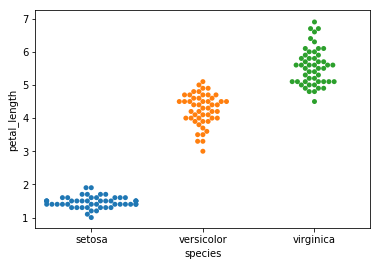

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load iris data
iris = sns.load_dataset("iris")

# Construct iris plot
sns.swarmplot(x="species", y="petal_length", data=iris)

# Show plot
plt.show()

(-0.001, 0.03)

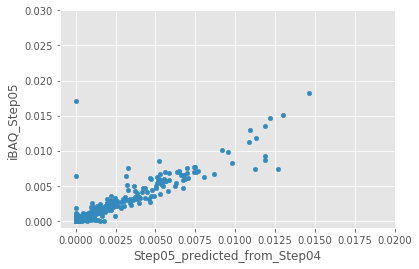

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
ax = prot_pct.plot.scatter(
    x='Step05_predicted_from_Step04',
    y='iBAQ_Step05',
)
ax.set_xlim((-0.001,0.020))
ax.set_ylim((-0.001,0.030))

In [ ]:
prot

In [19]:
%matplotlib inline
import altair as alt
from vega_datasets import data

iris = data.iris()

alt.Chart(iris).mark_point().encode(
    x='petalLength',
    y='petalWidth',
    color='species'
)

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/altair/utils/core.py:263: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


<VegaLite 2 object>

In [20]:
prot_pct

,Step05_predicted_from_W3110,Step09_predicted_from_Step05,Step10_predicted_from_Step09,Step10_predicted_from_W3110,iBAQ_Step04,iBAQ_Step05,iBAQ_Step09,iBAQ_Step10,iBAQ_W3110,$D_{KL}\left(\text{iBAQ_Step05}\|\text{Step05_predicted_from_W3110}\right)$,$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_Step09}\right)$,$D_{KL}\left(\text{iBAQ_Step09}\|\text{Step09_predicted_from_Step05}\right)$,$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_W3110}\right)$,$\log_2\left(\frac{\text{iBAQ_Step05}}{\text{Step05_predicted_from_W3110}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_Step09}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_W3110}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step09}}{\text{Step09_predicted_from_Step05}}\right)$
level_0,,,,,,,,,,,,,,,,,
b2977,0.000000,0.000000,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000,0.000038,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b2976,0.000000,0.000000,0.000000,0.000000,0.000203,0.000000,0.000000,0.000000,0.000113,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4034,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4035,0.000000,0.000000,0.000000,0.000000,0.000024,0.000000,0.000000,0.000000,0.000031,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4037,0.000000,0.000000,0.000000,0.000000,0.000048,0.000000,0.000000,0.000000,0.000095,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1152,0.000000,0.000000,0.000000,0.000000,0.000051,0.000000,0.000000,0.000000,0.000060,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1166,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000010,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1550,0.000000,0.000000,0.000000,0.000000,0.000894,0.000000,0.000000,0.000000,0.000957,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1557,0.000000,0.000000,0.000000,0.000000,0.000022,0.000000,0.000000,0.000000,0.000021,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN


# MaxMass applied to wild-type iBAQ

In [45]:
import os
prot_pct = pd.read_csv(os.path.join(os.environ['HOME'],'Projects/src',
                             'MaxMass/src/Visualizations',
                             'protein_mass_percent_predicted_from_previous_step.csv'),
                      index_col=0)
prot_pct

,Step05_predicted_from_W3110,Step09_predicted_from_Step05,Step10_predicted_from_Step09,Step10_predicted_from_W3110,iBAQ_Step04,iBAQ_Step05,iBAQ_Step09,iBAQ_Step10,iBAQ_W3110,$D_{KL}\left(\text{iBAQ_Step05}\|\text{Step05_predicted_from_W3110}\right)$,$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_Step09}\right)$,$D_{KL}\left(\text{iBAQ_Step09}\|\text{Step09_predicted_from_Step05}\right)$,$D_{KL}\left(\text{iBAQ_Step10}\|\text{Step10_predicted_from_W3110}\right)$,$\log_2\left(\frac{\text{iBAQ_Step05}}{\text{Step05_predicted_from_W3110}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_Step09}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step10}}{\text{Step10_predicted_from_W3110}}\right)$,$\log_2\left(\frac{\text{iBAQ_Step09}}{\text{Step09_predicted_from_Step05}}\right)$
level_0,,,,,,,,,,,,,,,,,
b2977,0.000000,0.000000,0.000000,0.000000,0.000096,0.000000,0.000000,0.000000,0.000038,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b2976,0.000000,0.000000,0.000000,0.000000,0.000203,0.000000,0.000000,0.000000,0.000113,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4034,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000020,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4035,0.000000,0.000000,0.000000,0.000000,0.000024,0.000000,0.000000,0.000000,0.000031,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b4037,0.000000,0.000000,0.000000,0.000000,0.000048,0.000000,0.000000,0.000000,0.000095,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1152,0.000000,0.000000,0.000000,0.000000,0.000051,0.000000,0.000000,0.000000,0.000060,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1166,0.000000,0.000000,0.000000,0.000000,0.000002,0.000000,0.000000,0.000000,0.000010,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1550,0.000000,0.000000,0.000000,0.000000,0.000894,0.000000,0.000000,0.000000,0.000957,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN
b1557,0.000000,0.000000,0.000000,0.000000,0.000022,0.000000,0.000000,0.000000,0.000021,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN


In [ ]:
import os
prot_pct = pd.read_csv(os.path.join(os.environ['HOME'],'Projects/src',
                             'MaxMass/src/Visualizations',
                             'protein_mass_percent_predicted_from_previous_step.csv'))
prot_pct

In [42]:
abundance = pd.read_table('data/Ecoli/A14.07036_cumulative_mass.tab', index_col='gene_or_promoter')

abundance = abundance.join(prot_pct['iBAQ_W3110']).sort_values('start',ascending=True)
#display(abundance)
abundance['iBAQ_W3110'] = abundance['iBAQ_W3110'].fillna(-abundance['iBAQ_W3110'].min())
#display(abundance)
abundance['iBAQ_W3110'] = abundance['iBAQ_W3110']/abundance['iBAQ_W3110'].sum()
#display(abundance)
abundance['iBAQ_W3110_cumulative_abundance'] = cumsum_k_minus_1( abundance['iBAQ_W3110'] )
abundance.to_csv(os.path.join(os.environ['HOME'],
                                                          'Projects/src/MaxMass/src',                    
                                                            'data/Ecoli/A14.07036_cumulative_mass_w_ibaq.tab'),
                                            sep='\t', index_label='gene_or_promoter')
abundance

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


,start,end,strand,class,genes_in_TU,start_if_select_as_start,cannot_as_start,Uniprot,Description,Gene,Cellular protein location (according to www.uniprot.org),A14.07036,A14.07037,A14.07038,cumulativeMass,iBAQ_W3110,iBAQ_W3110_cumulative_abundance
PM00249,148,189,1,promoter,"[b0001, b0002, b0003, b0004]",148,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,-8.181175e-07,0.000000e+00
b0001,190,255,1,gene,NaN,190,0,P0AD86,NaN,NaN,NaN,0.017912,NaN,NaN,0.017912,-8.181175e-07,-8.181175e-07
b0002,337,2799,1,gene,NaN,337,0,P00561,NaN,NaN,NaN,0.017912,NaN,NaN,0.035824,9.994742e-04,-1.636235e-06
b0003,2801,3733,1,gene,NaN,2801,0,P00547,Homoserine kinase OS=Escherichia coli (strain ...,thrB,Cytoplasm,0.033131,0.032556,0.033302,0.068954,1.744714e-04,9.978380e-04
b0004,3734,5020,1,gene,NaN,3734,0,P00934,NaN,NaN,NaN,0.017912,NaN,NaN,0.086866,1.579591e-03,1.172309e-03
b0005,5234,5530,1,gene,NaN,5234,0,P75616,NaN,NaN,NaN,0.017912,NaN,NaN,0.104778,-8.181175e-07,2.751901e-03
b0006,5683,6459,-1,gene,NaN,5683,0,P0A8I3,NaN,NaN,NaN,0.017912,NaN,NaN,0.122690,6.171662e-05,2.751083e-03
b0007,6529,7959,-1,gene,NaN,6529,0,P30143,NaN,NaN,NaN,0.017912,NaN,NaN,0.140602,-8.181175e-07,2.812799e-03
PM0-9956,8191,8237,1,promoter,[b0008],8191,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.140602,-8.181175e-07,2.811981e-03
b0008,8238,9191,1,gene,NaN,8238,0,P0A870,Transaldolase B OS=Escherichia coli (strain K1...,talB,Cytoplasm,0.620909,0.622423,0.610794,0.761511,2.556620e-03,2.811163e-03


In [42]:

abundance = pd.read_table('data/Ecoli/A14.07036_cumulative_mass.tab', index_col='gene_or_promoter')
ibaq = ['iBAQ_W3110', 'iBAQ_Step04','iBAQ_Step05', 'iBAQ_Step09', 'iBAQ_Step10']:
    
abundance = abundance.join(prot_pct[ibaq]).sort_values('start',ascending=True)
#display(abundance)
abundance[ibaq] = abundance[ibaq].fillna(-abundance[ibaq].min())
#display(abundance)
abundance[ibaq] = abundance['iBAQ_W3110']/abundance['iBAQ_W3110'].sum()
#display(abundance)
abundance['iBAQ_W3110_cumulative_abundance'] = cumsum_k_minus_1( abundance['iBAQ_W3110'] )
abundance.to_csv(os.path.join(os.environ['HOME'],
                                                          'Projects/src/MaxMass/src',                    
                                                            'data/Ecoli/A14.07036_cumulative_mass_w_ibaq.tab'),
                                            sep='\t', index_label='gene_or_promoter')
abundance

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.


,start,end,strand,class,genes_in_TU,start_if_select_as_start,cannot_as_start,Uniprot,Description,Gene,Cellular protein location (according to www.uniprot.org),A14.07036,A14.07037,A14.07038,cumulativeMass,iBAQ_W3110,iBAQ_W3110_cumulative_abundance
PM00249,148,189,1,promoter,"[b0001, b0002, b0003, b0004]",148,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,-8.181175e-07,0.000000e+00
b0001,190,255,1,gene,NaN,190,0,P0AD86,NaN,NaN,NaN,0.017912,NaN,NaN,0.017912,-8.181175e-07,-8.181175e-07
b0002,337,2799,1,gene,NaN,337,0,P00561,NaN,NaN,NaN,0.017912,NaN,NaN,0.035824,9.994742e-04,-1.636235e-06
b0003,2801,3733,1,gene,NaN,2801,0,P00547,Homoserine kinase OS=Escherichia coli (strain ...,thrB,Cytoplasm,0.033131,0.032556,0.033302,0.068954,1.744714e-04,9.978380e-04
b0004,3734,5020,1,gene,NaN,3734,0,P00934,NaN,NaN,NaN,0.017912,NaN,NaN,0.086866,1.579591e-03,1.172309e-03
b0005,5234,5530,1,gene,NaN,5234,0,P75616,NaN,NaN,NaN,0.017912,NaN,NaN,0.104778,-8.181175e-07,2.751901e-03
b0006,5683,6459,-1,gene,NaN,5683,0,P0A8I3,NaN,NaN,NaN,0.017912,NaN,NaN,0.122690,6.171662e-05,2.751083e-03
b0007,6529,7959,-1,gene,NaN,6529,0,P30143,NaN,NaN,NaN,0.017912,NaN,NaN,0.140602,-8.181175e-07,2.812799e-03
PM0-9956,8191,8237,1,promoter,[b0008],8191,0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.140602,-8.181175e-07,2.811981e-03
b0008,8238,9191,1,gene,NaN,8238,0,P0A870,Transaldolase B OS=Escherichia coli (strain K1...,talB,Cytoplasm,0.620909,0.622423,0.610794,0.761511,2.556620e-03,2.811163e-03


In [31]:
cumsum_k_minus_1(abundance['iBAQ_W3110'])

PM00249      0.000000e+00
b0001        8.125507e-07
b0002        1.625101e-06
b0003        9.942986e-04
b0004        1.167583e-03
b0005        2.736426e-03
b0006        2.737239e-03
b0007        2.798535e-03
PM0-9956     2.799348e-03
b0008        2.800160e-03
b0009        5.339384e-03
b0010        5.377993e-03
b0011        5.378805e-03
b0013        5.379618e-03
PM00316      5.380430e-03
b0014        5.381243e-03
b0015        7.222917e-03
b0016        7.324880e-03
b4412        7.325692e-03
b0018        7.326505e-03
b4413        7.327318e-03
b0019        7.328130e-03
b0020        7.328943e-03
b0021        7.329755e-03
b0022        7.330568e-03
b0023        7.331380e-03
PM0-8222     1.667777e-02
b0024        1.667859e-02
PM0-8866     1.667940e-02
b0025        1.668021e-02
                 ...     
b4383        9.979881e-01
b4384        9.982643e-01
b4385        9.989006e-01
b4386        9.989371e-01
b4387        9.989496e-01
PM00508      9.989504e-01
PM00509      9.989512e-01
b4388       

In [253]:
import io
solutionstr = """
,end,start,status
0,b0971,b0957,Optimal
1,b4433,b1823,Optimal
2,b3461,b3460,Optimal
3,b0024,b0023,Optimal
4,b4698,b1480,Optimal
5,b4674,b1324,Optimal
6,PM0-9375,b0755,Optimal
7,b4677,b1857,Optimal
8,b4595,b1237,Optimal
9,b4471,b3098,Optimal
10,PM0-10230,b1739,Optimal
"""

solution = pd.read_csv('../out/local_result_essential.csv',index_col=0)
solution['start'] = solution['start'].str.split('_').str.get(-1)
solution['end'] = solution['end'].str.split('_').str.get(-1)
solution['CCO'] = (abundance.loc[solution['end'], 
              'iBAQ_W3110'].reset_index()['iBAQ_W3110'] - abundance.loc[solution['start'], 'iBAQ_W3110'].reset_index()['iBAQ_W3110']).round(3)*100
solution[['start','end','CCO']]

,start,end,CCO
0,b4493,b1636,2.6
1,PM0-7163,b0628,1.9
2,b0955,b0971,1.8
3,b1813,b1852,1.7
4,b3465,b3559,1.6
5,b3635,b3636,1.5
6,b1913,PM0-7141,1.4
7,b3998,b4005,1.3
8,b0433,b0452,1.2
9,PM00577,b1779,1.2


In [241]:
abundance.loc['b0957':'b0971','iBAQ_W3110']

b0957    0.017035
b3636    0.031715
b4000    0.044674
b0605    0.056993
b1779    0.069052
b2414    0.081034
b2779    0.092381
b1823    0.103069
b3315    0.113712
b3312    0.124162
b2609    0.134340
b3460    0.143978
b3495    0.153475
b0023    0.162821
b3829    0.171653
b3341    0.180351
b4200    0.188965
b1480    0.196625
b3313    0.204063
b3307    0.211304
b3301    0.218331
b1136    0.225290
b3305    0.232170
b3303    0.239038
b3314    0.245692
b3298    0.252334
b1324    0.258933
b2925    0.265402
b0755    0.271786
b3317    0.278131
           ...   
b0900    0.998260
b0904    0.998261
b0906    0.998262
b0909    0.998263
b0913    0.998264
b0915    0.998264
b0916    0.998265
b0919    0.998266
b0926    0.998267
b0933    0.998268
b0934    0.998268
b0935    0.998269
b0936    0.998270
b0937    0.998271
b0938    0.998272
b0939    0.998273
b0940    0.998273
b0941    0.998274
b0942    0.998275
b0943    0.998276
b0944    0.998277
b0946    0.998277
b0950    0.998278
b0953    0.998279
b0958    0

# iBAQ excel

In [31]:
ibaq = pd.read_excel('CCO_iBAQ_MolPercentage.xlsx',
                       sheet_name='iBAQ_MolPerc', 
                       header=[0,1])\
            .xs('iBAQ',axis=1)
ibaq.columns

Index(['iBAQ DGF-298_22', 'iBAQ DGF-298_23', 'iBAQ DGF-298_24',
       'iBAQ MGF-01_10', 'iBAQ MGF-01_11', 'iBAQ MGF-01_12', 'iBAQ MGF-02_16',
       'iBAQ MGF-02_17', 'iBAQ MGF-02_18', 'iBAQ Step04_07', 'iBAQ Step04_08',
       'iBAQ Step04_09', 'iBAQ Step05_13', 'iBAQ Step05_14', 'iBAQ Step05_15',
       'iBAQ Step09_19', 'iBAQ Step09_20', 'iBAQ Step09_21', 'iBAQ Step10_04',
       'iBAQ Step10_05', 'iBAQ Step10_06', 'iBAQ W3110_01', 'iBAQ W3110_02',
       'iBAQ W3110_03'],
      dtype='object', name='Protein IDs')

In [33]:
melted_ibaq = ibaq.reset_index().melt(id_vars=['index'],value_name='iBAQ')
melted_ibaq['Replicate'] = melted_ibaq['Protein IDs'].str.split('_').str.get(-1)
melted_ibaq['Strain'] = melted_ibaq['Protein IDs'].str.split('_').str.get(0).str.split(' ').str.get(-1)
melted_ibaq

,index,Protein IDs,iBAQ,Replicate,Strain
0,W3110_lambdaRed.CDS.1007,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
1,W3110_lambdaRed.CDS.1014,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
2,W3110_lambdaRed.CDS.1034,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
3,W3110_lambdaRed.CDS.1035,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
4,W3110_lambdaRed.CDS.1036,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
5,W3110_lambdaRed.CDS.1038,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
6,W3110_lambdaRed.CDS.1041,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
7,W3110_lambdaRed.CDS.1042,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
8,W3110_lambdaRed.CDS.1043,iBAQ DGF-298_22,0.000000e+00,22,DGF-298
9,W3110_lambdaRed.CDS.1127,iBAQ DGF-298_22,0.000000e+00,22,DGF-298


In [28]:
melted_molpct.groupby(by=['index','Strain']).mean()

mol %
index                    Strain           
W3110_lambdaRed.CDS.1    DGF-298  0.179089
                         MGF-01   0.093845
                         MGF-02   0.109474
                         Step04   0.101340
                         Step05   0.186276
                         Step09   0.171936
                         Step10   0.194278
                         W3110    0.091442
W3110_lambdaRed.CDS.100  DGF-298  0.005234
                         MGF-01   0.003249
                         MGF-02   0.002654
                         Step04   0.002737
                         Step05   0.002648
                         Step09   0.002720
                         Step10   0.001419
                         W3110    0.001411
W3110_lambdaRed.CDS.1007 DGF-298  0.000274
                         MGF-01   0.005732
                         MGF-02   0.005529
                         Step04   0.004281
                         Step05   0.004207
                         Step09   0.002074
                         Step10   0.002355
                         W3110    0.005915
W3110_lambdaRed.CDS.101  DGF-298  0.048285
                         MGF-01   0.069444
                         MGF-02   0.064119
                         Step04   0.043813
                         Step05   0.060339
                         Step09   0.061571
...                                    ...
W3110_lambdaRed.CDS.992  MGF-02   0.009639
                         Step04   0.014899
                         Step05   0.014877
                         Step09   0.012866
                         Step10   0.013260
                         W3110    0.013727
W3110_lambdaRed.CDS.993  DGF-298  0.000000
                         MGF-01   0.007386
                         MGF-02   0.016598
                         Step04   0.012399
                         Step05   0.010575
                         Step09   0.013275
                         Step10   0.015128
                         W3110    0.003726
W3110_lambdaRed.CDS.994  DGF-298  0.000538
                         MGF-01   0.000392
                         MGF-02   0.000430
                         Step04   0.000680
                         Step05   0.000821
                         Step09   0.000537
                         Step10   0.000000
                         W3110    0.000000
W3110_lambdaRed.CDS.998  DGF-298  0.000272
                         MGF-01   0.000111
                         MGF-02   0.000293
                         Step04   0.000318
                         Step05   0.000569
                         Step09   0.000692
                         Step10   0.000652
                         W3110    0.000248

[15728 rows x 1 columns]

# KHK with violacin protein groups

In [3]:
w3110_to_MG1655 = pd.read_table('../../W3110-to-MG1655.tab')
w3110_to_MG1655

,W3110-ID,W3110-Name,W3110-Accession,MG1655-ID,Blattner,W3110-startbase,W3110-endbase,W3110-strand,MG1655-startbase,MG1655-endbase,MG1655-strand
0,JW4030,acs,ECK4062,EG11448,b4069,4289003,4290961,-,4285413,4287371,-
1,JW1299,pspC,ECK1301,EG10778,b1306,1370739,1371098,+,1369025,1369384,+
2,JW5245,yneE,ECK1513,G6807,b1520,1609822,1610736,-,1608108,1609022,-
3,JW1870,cheZ,ECK1882,EG10151,b1881,1968107,1968751,-,1966393,1967037,-
4,JW5856,trxA,ECK3773,EG11031,b3781,3670591,3670920,-,3965761,3966090,+
5,JW2398,xapA,ECK2401,G85,b2407,2529491,2530324,-,2524045,2524878,-
6,JW2935,yghD,ECK2963,G7535,b2968,3109246,3109782,-,3110590,3111126,-
7,JW0221,dinB,ECK0232,G6115,b0231,250898,251953,+,250898,251953,+
8,JW3467,gor,ECK3485,EG10412,b3500,3992764,3994116,-,3646299,3647651,+
9,JW0737,aroG,ECK0743,EG10079,b0754,786055,787107,+,785633,786685,+


In [1]:
import pandas as pd
import os
pg = pd.read_table( 'proteinGroups_shiftedColumn.txt')
pg_old = pd.read_table(os.path.join(os.environ['HOME'],'Projects/E.coli','proteinGroups.txt'))
pg

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,616,617) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Potential contaminant,id,Peptide IDs,Peptide is razor,Mod. peptide IDs,Evidence IDs,MS/MS IDs,Best MS/MS,Oxidation (M) site IDs,Oxidation (M) site positions
0,cat,cat,13,13,13,NaN,1.0,13.0,13.0,13.0,...,NaN,0.0,10717;14007;16931;16932;18031;18032;21640;2381...,True;True;True;True;True;True;True;True;True;T...,11676;15300;18510;18511;19716;19717;23654;2365...,658695;658696;658697;658698;658699;658700;6587...,436212;436213;436214;436215;436216;436217;4362...,436247;583704;707504;707519;757287;757334;9042...,0;1,67;185
1,CON__A2A4G1,CON__A2A4G1,13,4,3,NaN,1.0,13.0,4.0,3.0,...,+,1.0,10658;18835;18836;19335;19802;26218;30177;3328...,True;False;False;False;False;True;False;True;F...,11609;20606;20607;21136;21627;29246;33558;3697...,655278;1190172;1190173;1190174;1190175;1190176...,433957;792605;792606;792607;792608;792609;7926...,433957;792651;792653;811116;825211;1093493;124...,2,102
2,CON__ENSEMBL:ENSBTAP00000025008,CON__ENSEMBL:ENSBTAP00000025008,2,2,2,NaN,1.0,2.0,2.0,2.0,...,+,2.0,18098;19387,True;True,19787;21192,1138700;1138701;1138702;1138703;1138704;113870...,759836;759837;759838;759839;759840;759841;7598...,759843;814069,3,343
3,CON__ENSEMBL:ENSBTAP00000031900,CON__ENSEMBL:ENSBTAP00000031900,4,4,4,NaN,1.0,4.0,4.0,4.0,...,+,3.0,8923;13862;30695;35325,True;True;True;True,9729;15142;34127;39220,552205;552206;552207;552208;552209;552210;5522...,365566;365567;365568;574520;574521;574522;5745...,365566;574536;1266332;1457821,NaN,NaN
4,CON__ENSEMBL:ENSBTAP00000038253,CON__ENSEMBL:ENSBTAP00000038253,13,2,2,NaN,1.0,13.0,2.0,2.0,...,+,4.0,2041;3459;6551;8421;9947;18798;21427;26715;306...,True;False;False;False;False;False;False;True;...,2236;3837;7179;9197;10828;20566;23389;23390;29...,137322;237951;237952;237953;237954;237955;2379...,94274;162611;162612;162613;162614;162615;16261...,94274;162636;278733;350053;404993;790816;89411...,4,465
5,CON__P02533;CON__Q61782,CON__P02533,24;3,20;3,3;0,NaN,2.0,24.0,20.0,3.0,...,+,5.0,667;2265;3210;3688;8876;16119;16120;16612;1682...,True;True;True;True;True;True;True;True;True;T...,733;2483;3566;4079;9680;17591;17592;17593;1815...,46559;46560;154725;154726;154727;154728;154729...,31566;106472;106473;106474;106475;106476;10647...,31566;106473;151775;170200;363914;675903;67590...,2;5;6,119;212;287
6,CON__P02535-1,CON__P02535-1,14,2,2,NaN,1.0,14.0,2.0,2.0,...,+,6.0,2269;2270;2271;6555;15854;18835;18836;19771;21...,False;False;False;False;False;False;False;Fals...,2487;2488;2489;7183;17298;20606;20607;21595;22...,154842;154843;154844;154845;154846;154847;1548...,106518;106519;106520;106521;106522;106523;1065...,106521;106576;106581;278847;660094;792651;7926...,7,148
7,CON__P02538,CON__P02538,30,20,3,NaN,1.0,30.0,20.0,3.0,...,+,7.0,740;3459;6297;9272;9943;9946;12498;12823;12906...,True;False;True;False;True;True;True;True;True...,810;3837;6908;10105;10824;10827;13655;14015;14...,50844;50845;50846;50847;50848;50849;50850;5085...,33985;33986;162611;162612;162613;162614;162615...,33985;162636;270038;377050;404934;404954;51625...,NaN,NaN
8,CON__P02662,CON__P02662,2,2,2,NaN,1.0,2.0,2.0,2.0,...,+,8.0,13970;39864,True;True,15259;44165,870518;870519;870520;870521;870522;870523;8705...,581621;581622;581623;581624;581625;581626;5816...,581625;1646082,NaN,NaN
9,CON__P02663,CON__P02663,5,5,5,NaN,1.0,5.0,5.0,5.0,...,+,9.0,2868;9236;9237;22744;33953,True;True;True;True;True,3165;10068;10069;24866;37700,198816;568360;568361;568362;568363;568364;5683...,136112;375802;375803;942386;1401437,136112;375802;375803;942386;1401437,NaN,NaN


In [2]:
ibaq_col = [c for c in pg.columns if 'iBAQ' in c]
ibaq_df = pg.set_index('Protein IDs')[ibaq_col]
del ibaq_df['iBAQ']
nonnative = [idx for idx in ibaq_df.index if 'W3110' not in idx and len(idx) < 100]
native = [idx for idx in ibaq_df.index if 'W3110'  in idx and 'REV' not in idx]
ibaq_df.loc[nonnative].dropna(how='all')

,iBAQ AC1_control_1_01,iBAQ AC1_control_2_02,iBAQ AC1_control_3_03,iBAQ AC1_cumate_1_04,iBAQ AC1_cumate_2_05,iBAQ AC1_cumate_3_06,iBAQ AC13_control_1_19,iBAQ AC13_control_2_20,iBAQ AC13_control_3_21,iBAQ AC13_cumate_1_22,...,iBAQ AC8_control_3_09,iBAQ AC8_cumate_1_10,iBAQ AC8_cumate_2_11,iBAQ AC8_cumate_3_12,iBAQ AC9_control_1_13,iBAQ AC9_control_2_14,iBAQ AC9_control_3_15,iBAQ AC9_cumate_1_16,iBAQ AC9_cumate_2_17,iBAQ AC9_cumate_3_18
Protein IDs,,,,,,,,,,,,,,,,,,,,,
cat,2.086900e+09,2.323400e+09,2.301000e+09,7.239800e+08,1.153500e+09,9.373600e+08,4.799000e+09,3.537800e+09,2.915600e+09,1.371900e+09,...,3.733600e+09,1.333200e+09,1.334800e+09,1.576100e+09,3.736700e+09,3.146200e+09,2.873900e+09,1.007400e+09,1.561200e+09,1.341900e+09
CON__A2A4G1,3.712900e+05,0.000000e+00,0.000000e+00,1.163200e+05,1.797000e+05,1.428000e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.979400e+05,...,0.000000e+00,2.797000e+05,0.000000e+00,2.878100e+05,0.000000e+00,0.000000e+00,0.000000e+00,4.893600e+04,0.000000e+00,0.000000e+00
CON__ENSEMBL:ENSBTAP00000025008,1.304700e+06,2.842400e+06,1.466400e+06,0.000000e+00,3.818300e+05,0.000000e+00,2.396500e+06,1.920500e+06,2.348300e+06,2.869700e+05,...,6.960800e+05,1.144800e+06,0.000000e+00,4.939700e+05,1.545100e+06,1.381100e+06,1.278300e+06,0.000000e+00,0.000000e+00,0.000000e+00
CON__ENSEMBL:ENSBTAP00000031900,0.000000e+00,3.827800e+05,3.220900e+05,0.000000e+00,0.000000e+00,0.000000e+00,6.970800e+05,5.050000e+05,2.502500e+05,1.997900e+05,...,3.870500e+05,0.000000e+00,2.425000e+05,1.025500e+06,0.000000e+00,4.222100e+05,0.000000e+00,0.000000e+00,0.000000e+00,4.606600e+04
CON__ENSEMBL:ENSBTAP00000038253,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
CON__P02533;CON__Q61782,1.082600e+06,1.934900e+06,7.063400e+05,7.758700e+05,4.129500e+05,1.034300e+07,5.130700e+06,5.235300e+06,1.094000e+06,2.631400e+06,...,4.134400e+06,1.400200e+06,1.772900e+06,5.115700e+05,1.419100e+06,5.582000e+05,4.145100e+05,5.249800e+05,3.800000e+06,1.523500e+07
CON__P02535-1,0.000000e+00,5.675600e+05,7.637600e+05,5.157200e+05,0.000000e+00,3.446600e+05,0.000000e+00,0.000000e+00,7.100800e+05,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.511100e+05,3.322500e+05,0.000000e+00,5.967400e+05
CON__P02538,3.530400e+06,5.326000e+06,2.482300e+06,2.807900e+06,7.049700e+06,8.554400e+06,4.210100e+06,8.651200e+06,1.639900e+06,2.008900e+06,...,2.248600e+06,1.992900e+06,1.402600e+06,7.907400e+05,3.570000e+06,3.218400e+06,5.720600e+06,1.272200e+06,4.450600e+06,1.432400e+07
CON__P02662,1.352400e+07,3.587100e+05,4.123000e+05,9.256400e+04,2.896900e+05,1.044300e+06,4.080100e+06,2.409800e+06,4.934500e+05,3.523200e+06,...,9.091000e+05,1.006400e+06,1.023100e+06,1.157700e+07,0.000000e+00,1.576600e+06,0.000000e+00,0.000000e+00,1.328700e+06,1.772000e+06


In [91]:
ibaq_df.columns

Index(['iBAQ AC1_control_1_01', 'iBAQ AC1_control_2_02',
       'iBAQ AC1_control_3_03', 'iBAQ AC1_cumate_1_04', 'iBAQ AC1_cumate_2_05',
       'iBAQ AC1_cumate_3_06', 'iBAQ AC13_control_1_19',
       'iBAQ AC13_control_2_20', 'iBAQ AC13_control_3_21',
       'iBAQ AC13_cumate_1_22', 'iBAQ AC13_cumate_2_23',
       'iBAQ AC13_cumate_3_24', 'iBAQ AC14_control_1_25',
       'iBAQ AC14_control_2_26', 'iBAQ AC14_control_3_27',
       'iBAQ AC14_cumate_1_28', 'iBAQ AC14_cumate_2_29',
       'iBAQ AC14_cumate_3_30', 'iBAQ AC14_lowOD_control_1_61',
       'iBAQ AC14_lowOD_control_2_62', 'iBAQ AC14_lowOD_control_3_63',
       'iBAQ AC14_lowOD_cumate_1_64', 'iBAQ AC14_lowOD_cumate_2_65',
       'iBAQ AC14_lowOD_cumate_3_66', 'iBAQ AC17_control_1_31',
       'iBAQ AC17_control_2_32', 'iBAQ AC17_control_3_33',
       'iBAQ AC17_cumate_1_34', 'iBAQ AC17_cumate_2_35',
       'iBAQ AC17_cumate_3_36', 'iBAQ AC18_control_1_37',
       'iBAQ AC18_control_2_38', 'iBAQ AC18_control_3_39',
       'iBAQ AC

In [92]:
ibaq_df.loc[native]

,iBAQ AC1_control_1_01,iBAQ AC1_control_2_02,iBAQ AC1_control_3_03,iBAQ AC1_cumate_1_04,iBAQ AC1_cumate_2_05,iBAQ AC1_cumate_3_06,iBAQ AC13_control_1_19,iBAQ AC13_control_2_20,iBAQ AC13_control_3_21,iBAQ AC13_cumate_1_22,...,iBAQ AC8_control_3_09,iBAQ AC8_cumate_1_10,iBAQ AC8_cumate_2_11,iBAQ AC8_cumate_3_12,iBAQ AC9_control_1_13,iBAQ AC9_control_2_14,iBAQ AC9_control_3_15,iBAQ AC9_cumate_1_16,iBAQ AC9_cumate_2_17,iBAQ AC9_cumate_3_18
Protein IDs,,,,,,,,,,,,,,,,,,,,,
W3110_lambdaRed.CDS.1,2.350200e+07,3.193400e+07,2.554200e+07,1.654800e+07,2.441000e+07,1.947300e+07,1.220500e+08,9.979300e+07,9.057800e+07,6.014900e+07,...,5.745700e+07,4.140300e+07,4.175500e+07,3.717000e+07,5.836000e+07,5.216400e+07,6.746600e+07,2.978600e+07,4.026100e+07,2.983000e+07
W3110_lambdaRed.CDS.100,5.686000e+06,1.026200e+07,8.857100e+06,5.477000e+06,5.541200e+06,5.365400e+06,1.169600e+07,4.286700e+06,6.860000e+06,8.701400e+06,...,8.656100e+06,6.711300e+06,5.375100e+06,4.620800e+06,4.975500e+06,7.522100e+06,1.275200e+07,3.949300e+06,4.472500e+06,3.117600e+06
W3110_lambdaRed.CDS.1007,9.791300e+06,4.132000e+07,3.925700e+06,5.920000e+06,8.454500e+06,8.007600e+06,1.067500e+07,8.670600e+06,6.531000e+07,3.553000e+07,...,6.482300e+06,8.093000e+06,3.680100e+07,2.739200e+07,5.182700e+07,5.327100e+07,6.971700e+07,3.688000e+06,4.199900e+07,5.726400e+06
W3110_lambdaRed.CDS.101,2.076600e+08,3.170900e+08,2.204000e+08,1.070300e+08,1.385100e+08,1.226400e+08,3.575400e+08,3.309800e+08,3.006400e+08,1.343200e+08,...,3.235400e+08,1.384600e+08,1.276500e+08,1.534300e+08,3.803400e+08,3.447100e+08,4.525800e+08,9.744000e+07,1.485300e+08,1.198800e+08
W3110_lambdaRed.CDS.1011,2.807500e+07,3.617400e+07,4.366300e+07,3.102500e+07,3.917000e+07,3.933400e+07,6.967900e+07,5.978300e+07,4.420700e+07,5.063200e+07,...,4.938300e+07,2.768700e+07,2.639900e+07,2.867500e+07,5.643800e+07,4.880200e+07,5.850000e+07,2.065000e+07,3.532600e+07,2.593900e+07
W3110_lambdaRed.CDS.1012,1.351200e+07,1.864500e+07,1.753000e+07,6.882600e+06,1.200400e+07,1.122400e+07,1.643300e+07,1.501200e+07,1.478400e+07,6.729300e+06,...,2.357400e+07,8.257200e+06,9.893500e+06,1.047100e+07,1.846100e+07,1.933500e+07,1.511800e+07,5.390300e+06,1.121600e+07,5.712600e+06
W3110_lambdaRed.CDS.1014,1.427000e+07,3.711400e+07,5.695500e+07,1.214800e+07,2.825100e+07,2.048500e+07,6.381500e+07,1.681200e+07,4.253800e+07,1.529800e+07,...,7.969100e+07,1.682000e+07,1.349700e+07,6.018100e+07,6.156500e+07,2.204800e+07,5.622300e+06,5.897800e+06,1.030000e+07,2.044400e+07
W3110_lambdaRed.CDS.1016,6.003900e+06,1.127500e+07,2.707000e+06,2.278900e+06,4.047800e+06,3.606200e+06,6.944700e+06,2.012000e+06,3.896100e+06,6.592100e+06,...,8.038800e+06,4.443800e+06,3.507000e+06,3.473400e+06,5.825700e+06,7.705900e+06,8.112400e+06,1.375500e+06,6.005900e+06,3.929700e+06
W3110_lambdaRed.CDS.1017,6.578600e+06,1.601700e+07,7.483200e+06,1.928600e+06,1.588500e+06,2.789800e+06,7.342000e+06,8.934400e+06,7.996200e+06,1.362600e+06,...,7.482500e+06,3.047900e+06,3.998600e+06,2.197500e+06,8.824700e+06,8.883200e+06,2.525500e+07,2.152500e+06,3.447800e+06,2.165100e+06


In [8]:
from IPython.display import HTML

khk_sample_conditions = pd.read_csv('KHK10_sample_conditions.csv',index_col='Sample_number')
HTML(khk_sample_conditions.to_html())

,AC_number,KHK_step,Condition,Replicate,Extraction_OD
Sample_number,,,,,
1,AC01,W3110,control,1,0.24
2,AC01,W3110,control,2,0.24
3,AC01,W3110,control,3,0.19
4,AC01,W3110,cumate,1,0.20
5,AC01,W3110,cumate,2,0.20
6,AC01,W3110,cumate,3,0.20
7,AC08,Step_06,control,1,0.24
8,AC08,Step_06,control,2,0.24
9,AC08,Step_06,control,3,0.24


In [25]:
locus = pd.read_table('../../lambdaRed_W3110_MG1655.locus.tab',index_col='E_coli_K12_W3110_lambdaRed')
locus

ibaq_w_locus = ibaq_df.join(locus,how='inner')

  
ibaq_w_locus.reset_index().set_index('Blattner').to_csv('E.coli_iBAQ_induced_v_uninduced.tab',sep='\t')
AC = pd.Series(dict([(int(ac.split('_')[-1]), ac) 
                     for ac in ibaq_w_locus.columns 
                     if 'iBAQ AC' in ac]))
khk_sample_conditions['iBAQ'] = AC
khk_index = khk_sample_conditions.reset_index().set_index(['AC_number', 'KHK_step', 'Condition', 'Replicate',  'iBAQ']).index

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (5 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [27]:
ibaq_df.columns = khk_index
ibaq_df.loc[native]

AC_number                         AC01                              \
KHK_step                         W3110                               
Condition                      control                               
Replicate                            1             2             3   
iBAQ                               NaN           NaN           NaN   
Protein IDs                                                          
W3110_lambdaRed.CDS.1     2.350200e+07  3.193400e+07  2.554200e+07   
W3110_lambdaRed.CDS.100   5.686000e+06  1.026200e+07  8.857100e+06   
W3110_lambdaRed.CDS.1007  9.791300e+06  4.132000e+07  3.925700e+06   
W3110_lambdaRed.CDS.101   2.076600e+08  3.170900e+08  2.204000e+08   
W3110_lambdaRed.CDS.1011  2.807500e+07  3.617400e+07  4.366300e+07   
W3110_lambdaRed.CDS.1012  1.351200e+07  1.864500e+07  1.753000e+07   
W3110_lambdaRed.CDS.1014  1.427000e+07  3.711400e+07  5.695500e+07   
W3110_lambdaRed.CDS.1016  6.003900e+06  1.127500e+07  2.707000e+06   
W3110_lambdaRed.CDS.1017  6.578600e+06  1.601700e+07  7.483200e+06   
W3110_lambdaRed.CDS.1018  1.345200e+07  1.689200e+07  1.389700e+07   
W3110_lambdaRed.CDS.1022  9.765700e+06  1.683600e+07  1.769600e+07   
W3110_lambdaRed.CDS.1024  1.515000e+07  4.024300e+07  1.939500e+07   
W3110_lambdaRed.CDS.1025  1.788800e+08  3.403400e+08  2.809900e+08   
W3110_lambdaRed.CDS.1026  9.749800e+06  1.275000e+07  1.154700e+07   
W3110_lambdaRed.CDS.1027  4.639000e+07  5.896400e+07  5.521000e+07   
W3110_lambdaRed.CDS.1029  5.214200e+06  7.494000e+06  6.432900e+06   
W3110_lambdaRed.CDS.1030  1.987000e+07  3.563500e+07  2.741900e+07   
W3110_lambdaRed.CDS.1031  3.412900e+05  0.000000e+00  1.551300e+06   
W3110_lambdaRed.CDS.1032  0.000000e+00  0.000000e+00  0.000000e+00   
W3110_lambdaRed.CDS.1033  1.094700e+07  1.541300e+07  1.202700e+07   
W3110_lambdaRed.CDS.1034  1.968500e+08  4.326300e+08  3.361200e+08   
W3110_lambdaRed.CDS.1035  2.050600e+08  2.791400e+08  1.265700e+07   
W3110_lambdaRed.CDS.1036  3.502400e+07  5.229000e+07  3.498400e+07   
W3110_lambdaRed.CDS.1037  1.567000e+07  2.952200e+07  2.087600e+07   
W3110_lambdaRed.CDS.1038  1.475500e+07  2.994400e+07  2.251100e+07   
W3110_lambdaRed.CDS.1039  1.981700e+08  2.108500e+08  2.121500e+08   
W3110_lambdaRed.CDS.1040  1.511300e+07  4.790600e+07  3.177600e+07   
W3110_lambdaRed.CDS.1041  4.906800e+06  6.135900e+06  4.848100e+06   
W3110_lambdaRed.CDS.1042  1.026100e+08  1.387500e+08  1.141700e+08   
W3110_lambdaRed.CDS.1043  2.653100e+07  3.815300e+07  3.003400e+07   
...                                ...           ...           ...   
W3110_lambdaRed.CDS.953   8.927800e+06  1.180400e+07  1.203600e+07   
W3110_lambdaRed.CDS.954   7.884700e+06  1.354100e+07  7.458700e+06   
W3110_lambdaRed.CDS.955   1.217600e+07  1.818900e+07  1.958400e+07   
W3110_lambdaRed.CDS.957   8.194400e+06  1.144400e+07  1.003200e+07   
W3110_lambdaRed.CDS.958   3.743000e+06  0.000000e+00  0.000000e+00   
W3110_lambdaRed.CDS.959   1.363800e+08  1.923900e+08  1.866700e+08   
W3110_lambdaRed.CDS.96    8.580400e+07  1.051700e+08  9.898800e+07   
W3110_lambdaRed.CDS.960   8.810000e+06  1.195700e+07  1.084800e+07   
W3110_lambdaRed.CDS.961   4.475700e+06  2.562000e+06  5.188500e+06   
W3110_lambdaRed.CDS.962   4.440400e+09  6.388700e+09  5.388900e+09   
W3110_lambdaRed.CDS.965   1.495900e+06  1.994600e+06  8.053700e+05   
W3110_lambdaRed.CDS.966   5.657100e+06  4.763300e+06  0.000000e+00   
W3110_lambdaRed.CDS.967   1.574900e+07  1.947000e+07  2.000300e+07   
W3110_lambdaRed.CDS.968   1.369500e+07  4.515200e+07  1.671200e+07   
W3110_lambdaRed.CDS.971   4.127300e+06  4.765700e+06  2.423600e+06   
W3110_lambdaRed.CDS.972   4.667300e+07  1.914900e+07  6.922300e+07   
W3110_lambdaRed.CDS.973   1.875000e+07  2.622200e+07  1.597100e+07   
W3110_lambdaRed.CDS.974   0.000000e+00  1.478300e+06  0.000000e+00   
W3110_lambdaRed.CDS.975   1.703300e+07  1.625400e+07  1.702200e+07   
W3110_lambdaRed.CDS.977   0.000000e+00  0.000000e+00  0.000000e+00   
W3110_lamb

In [31]:
import numpy as np
ibaq_avg = ibaq_df.groupby(level=['AC_number','KHK_step','Condition'],axis=1).mean()
ibaq_avg.loc[native]
total_protein = ibaq_avg.sum(axis=0)
norm_ibaq = ibaq_avg/total_protein
log10_norm_ibaq = norm_ibaq.apply(np.log10)
log10_norm_ibaq.to_csv('log10_norm_ibaq.tab',sep='\t')
pd.DataFrame([log10_norm_ibaq.max(axis=0), 
              log10_norm_ibaq\
              .replace( -np.inf, np.nan)\
              .fillna( 1000)\
              .min(axis=0)
              ])
log10_norm_ibaq.max(axis=0).max(),log10_norm_ibaq.replace( -np.inf, np.nan)\
              .fillna( 1000)\
              .min(axis=0).min() 
norm_ibaq.max(axis=1).argmax(),norm_ibaq.replace( 0, np.nan)\
              .fillna( 1000)\
              .min(axis=1).argmin() 
norm_ibaq.loc['W3110_lambdaRed.CDS.3307'].to_frame('W3110_lambdaRed.CDS.3307')

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:15: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


W3110_lambdaRed.CDS.3307
AC_number KHK_step Condition                          
AC01      W3110    control                    0.028921
                   cumate                     0.031526
AC08      Step_06  control                    0.025563
                   cumate                     0.025834
AC09      Step_07  control                    0.020408
                   cumate                     0.021453
AC13      Step_11  control                    0.023677
                   cumate                     0.032585
AC14      Step_12  control                    0.028332
                   cumate                     0.029322
AC17      Step_15  control                    0.030023
                   cumate                     0.029621
AC18      Step_16  control                    0.028435
                   cumate                     0.030236
AC31      MGF-01   control                    0.028555
                   cumate                     0.028428
AC33      MGF-02   control                    0.027135
                   cumate                     0.027041
AC34      DGF-298  control                    0.026747
                   cumate                     0.031812

In [29]:
st_columns = []
for AC, KHK_step, condition in log10_norm_ibaq.columns:
    st_columns.append('{}_{}'.format(KHK_step, condition))
    
log10_norm_ibaq.columns = st_columns
log10_norm_ibaq.join(locus,how='inner')\
             .reset_index()\
             .set_index('Blattner')\
             .to_csv('log10_norm_ibaq_blattner.tab',sep='\t')
log10_norm_ibaq.loc[native].join(locus,how='inner')\
             .reset_index()\
             .set_index('Blattner')

,index,W3110_control,W3110_cumate,Step_06_control,Step_06_cumate,Step_07_control,Step_07_cumate,Step_11_control,Step_11_cumate,Step_12_control,...,W3110-Name,W3110-Accession,MG1655-ID,W3110-startbase,W3110-endbase,W3110-strand,MG1655-startbase,MG1655-endbase,MG1655-strand,sort_order
Blattner,,,,,,,,,,,,,,,,,,,,,
b0002,W3110_lambdaRed.CDS.1,-4.181154,-4.156825,-3.669261,-3.722693,-3.455502,-3.629740,-3.755394,-3.817768,-3.757089,...,thrA,ECK0002,EG10998,337,2799,+,337,2799,+,1
b0103,W3110_lambdaRed.CDS.100,-4.694980,-4.723676,-4.805254,-4.692835,-4.716593,-4.823924,-4.670024,-4.593469,-4.803967,...,coaE,ECK0103,EG12312,112599,113219,-,112599,113219,-,100
b1045,W3110_lambdaRed.CDS.1007,-4.348867,-4.588184,-4.236346,-3.939903,-4.161793,-3.983265,-4.116484,-3.583738,-3.851729,...,ymdB,ECK1031,G6550,1107397,1107930,+,1105820,1106353,+,1007
b0104,W3110_lambdaRed.CDS.101,-3.217278,-3.372025,-3.168735,-3.335285,-3.104693,-3.200599,-3.089585,-3.141306,-3.058840,...,guaC,ECK0104,EG10422,113444,114487,+,113444,114487,+,101
b1048,W3110_lambdaRed.CDS.1011,-4.056452,-3.898556,-3.924279,-3.793017,-3.485211,-3.596863,-3.773681,-4.219812,-3.897405,...,opgG,ECK1034,EG11885,1110912,1112447,+,1109335,1110870,+,1011
b1049,W3110_lambdaRed.CDS.1012,-4.393279,-4.459366,-4.499087,-4.528182,-4.448338,-4.507295,-4.380888,-4.538374,-4.406865,...,opgH,ECK1035,EG11886,1112440,1114983,+,1110863,1113406,+,1012
b1051,W3110_lambdaRed.CDS.1014,-4.054736,-4.153582,-4.073514,-4.259191,-3.558050,-3.812288,-3.582655,-4.246757,-3.920355,...,msyB,ECK1037,EG11338,1115384,1115758,-,1113807,1114181,-,1014
b1054,W3110_lambdaRed.CDS.1016,-4.788798,-4.941009,-5.055004,-4.799080,-4.988863,-4.701268,-4.895192,-4.499705,-4.869808,...,lpxL,ECK1039,EG10464,1117239,1118159,-,1115662,1116582,-,1016
b1055,W3110_lambdaRed.CDS.1017,-4.611261,-5.138269,-4.778885,-5.103343,-5.803471,-6.497181,-5.128785,-4.675516,-4.562555,...,yceA,ECK1040,EG11116,1118384,1119436,+,1116807,1117859,+,1017


In [1]:
!pwd

/Users/zuck016/Projects/E.coli/synbio-ai/CCO-divergence-analysis


In [22]:
log2fc_norm_ibaq = norm_ibaq.xs('cumate', 
             level='Condition',
             axis=1)\
         .apply(np.log2) - norm_ibaq.xs('control',
                                       level = 'Condition',
                                       axis=1)\
                                    .apply(np.log2)
log2fc_norm_ibaq_blattner = log2fc_norm_ibaq.join(locus['Blattner'],how='inner').set_index('Blattner')
log2fc_norm_ibaq_blattner.columns = log2fc_norm_ibaq.columns.droplevel('AC_number')
#log2fc_norm_ibaq_blattner = log2fc_norm_ibaq_blattner.replace([-np.inf, np.inf], np.nan)
log2fc_norm_ibaq_blattner.to_csv('log2fc_norm_ibaq_blattner.tab',sep='\t')
log2fc_norm_ibaq_blattner

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


KHK_step,W3110,Step_06,Step_07,Step_11,Step_12,Step_15,Step_16,MGF-01,MGF-02,DGF-298
Blattner,,,,,,,,,,
b0002,0.080819,-0.177495,-0.578804,-0.207202,-0.392865,-0.763067,-0.414698,-0.927327,0.027974,0.179116
b0103,-0.095324,0.373449,-0.356545,0.254311,0.140737,0.750030,0.276910,0.541946,0.408351,0.187530
b1045,-0.794996,0.984763,0.593060,1.769746,-1.025889,0.646915,-1.425667,0.043230,0.008071,0.813247
b0104,-0.514059,-0.553267,-0.318596,-0.171812,-0.665561,-0.734697,-0.399079,-0.420347,-0.621844,-0.581817
b1048,0.524518,0.436044,-0.370899,-1.482015,0.109223,0.338280,-0.032985,0.053983,0.059624,-0.246835
b1049,-0.219537,-0.096650,-0.195851,-0.523158,-0.391362,-0.680990,-0.443271,-0.365676,-0.217764,-0.195663
b1051,-0.328357,-0.616805,-0.844561,-2.206101,-0.145403,-0.464014,-1.388694,-3.067191,-0.866968,-0.725963
b1054,-0.505635,0.850161,0.955372,1.313780,0.181216,1.040523,1.053685,0.021344,0.424529,-0.257780
b1055,-1.750684,-1.077826,-2.304456,1.505728,-1.331377,-1.423301,-0.650818,0.526610,-0.599606,-0.622903


In [136]:
locus.loc['W3110_lambdaRed.CDS.3307']

E_coli_K12_W3110     JW3943
W3110-Name             tufB
W3110-Accession     ECK3971
MG1655-ID           EG11036
Blattner              b3339
W3110-startbase     3459553
W3110-endbase       3460737
W3110-strand              -
MG1655-startbase    3470145
MG1655-endbase      3471329
MG1655-strand             -
sort_order             3307
Name: W3110_lambdaRed.CDS.3307, dtype: object

## iBAQ Mass percentage cleaned (Ernesto)

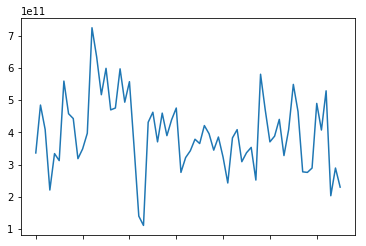

In [104]:
import numpy as np
total_protein = ibaq_df.sum(axis=0)
normalized_ibaq = ibaq_df/total_protein*100
total_protein*.plot()

In [5]:
import pandas as pd
ibaq_mass_pct = 'iBAQ_Mass_Percentage_Clean_20181101'
ibaqmp = pd.read_excel('{}.xlsx'.format(ibaq_mass_pct), 
                       sheet_name='Sheet1',
                      index_col='Main IDs')
ibaqmp.loc['W3110_lambdaRed.CDS.1235',
           ['Step_12_lowOD_control_1_61',
           'Step_12_lowOD_control_2_62',
           'Step_12_lowOD_control_3_63']].mean()
RFP = 'W3110_lambdaRed.CDS.772'
GFP = 'W3110_lambdaRed.CDS.771'

/Users/zuck016/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/pandas/plotting/_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


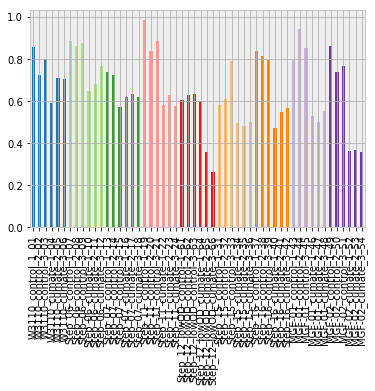

In [34]:
%matplotlib inline
gfp_rfp = ibaqmp.loc[GFP:RFP,ibaqmp.columns[9:]]
#gfp_rfp.T.plot(kind='bar')
gfp = gfp_rfp.loc[GFP]
gfp.plot(kind='bar',colors=hextuple_hex)

In [45]:
gfp_rfp

,W3110_control_1_01,W3110_control_2_02,W3110_control_3_03,W3110_cumate_1_04,W3110_cumate_2_05,W3110_cumate_3_06,Step_06_control_1_07,Step_06_control_2_08,Step_06_control_3_09,Step_06_cumate_1_10,...,MGF-01_control_3_45,MGF-01_cumate_1_46,MGF-01_cumate_2_47,MGF-01_cumate_3_48,MGF-02_control_1_49,MGF-02_control_2_50,MGF-02_control_3_51,MGF-02_cumate_1_52,MGF-02_cumate_2_53,MGF-02_cumate_3_54
Main IDs,,,,,,,,,,,,,,,,,,,,,
W3110_lambdaRed.CDS.771,0.853475,0.720625,0.796347,0.588319,0.709944,0.701619,0.885689,0.861762,0.872742,0.645690,...,0.851009,0.529192,0.499261,0.552152,0.858377,0.736148,0.766730,0.359651,0.368559,0.355348
W3110_lambdaRed.CDS.772,0.300548,0.321014,0.336329,0.363416,0.475049,0.431581,0.386223,0.360474,0.344880,0.335884,...,0.298447,0.392834,0.395329,0.312020,0.361105,0.377632,0.352762,0.314720,0.331672,0.364108


In [48]:
ibaqmp.sort_values(by='W3110_control_1_01', axis=0,ascending=False)

,Protein IDs,Peptides,Sequence coverage [%],Mol. weight [kDa],Mol. weight [Da],Sequence length,Q-value,Score,W3110_ave,W3110_control_1_01,...,MGF-01_control_3_45,MGF-01_cumate_1_46,MGF-01_cumate_2_47,MGF-01_cumate_3_48,MGF-02_control_1_49,MGF-02_control_2_50,MGF-02_control_3_51,MGF-02_cumate_1_52,MGF-02_cumate_2_53,MGF-02_cumate_3_54
Main IDs,,,,,,,,,,,,,,,,,,,,,
W3110_lambdaRed.CDS.3307,W3110_lambdaRed.CDS.3307,74,100.0,43.3130,43313.0,394,0.000000,323.3100,4.854732,5.199502,...,4.676611,4.297635,4.902470,5.446667,4.533275,4.338858,4.807483,4.476456,3.968923,5.239219
W3110_lambdaRed.CDS.962,W3110_lambdaRed.CDS.962,40,75.7,38.1320,38132.0,354,0.000000,323.3100,1.935384,1.956884,...,1.814086,1.974276,2.129351,2.270483,1.487557,1.438113,1.513087,1.748327,1.530918,1.854583
W3110_lambdaRed.CDS.1767,W3110_lambdaRed.CDS.1767;W3110_lambdaRed.CDS.1398,70,99.7,35.5320,35532.0,331,0.000000,323.3100,1.489170,1.562035,...,1.595103,1.438534,1.535000,1.801806,1.202079,1.321538,1.424992,1.261559,1.328275,1.282581
W3110_lambdaRed.CDS.2778,W3110_lambdaRed.CDS.2778,73,98.4,45.6540,45654.0,432,0.000000,323.3100,1.560996,1.530400,...,1.300059,1.818978,1.811830,1.639625,0.867067,0.958743,0.963913,1.504802,1.556919,1.441404
W3110_lambdaRed.CDS.4170,W3110_lambdaRed.CDS.4170,98,99.8,57.3280,57328.0,548,0.000000,323.3100,1.434842,1.454700,...,1.401814,1.945606,2.048909,1.978775,1.374951,1.393248,1.278690,1.660437,1.655003,1.772868
W3110_lambdaRed.CDS.2419,W3110_lambdaRed.CDS.2419,54,98.8,34.4890,34489.0,323,0.000000,323.3100,1.407766,1.432557,...,1.715464,1.407164,1.492410,1.498465,2.058661,1.956943,2.185746,1.361977,1.483568,1.570655
W3110_lambdaRed.CDS.3542,W3110_lambdaRed.CDS.3542,67,98.0,50.3250,50325.0,460,0.000000,323.3100,1.316785,1.418622,...,1.166468,0.903437,1.015836,1.039468,0.860659,0.885737,0.950518,1.007051,0.906015,1.040661
W3110_lambdaRed.CDS.3959,W3110_lambdaRed.CDS.3959,111,92.6,77.5800,77580.0,704,0.000000,323.3100,1.296724,1.297752,...,1.261354,1.301253,1.288589,1.319108,1.082611,1.031775,1.162501,1.492042,1.543761,1.407974
W3110_lambdaRed.CDS.3958,W3110_lambdaRed.CDS.3958,35,94.4,20.0190,20019.0,179,0.000000,323.3100,1.259050,1.186018,...,0.972747,0.946710,1.004220,0.898384,1.102869,1.043124,0.972478,1.204877,1.165992,1.161578


In [ ]:
from plotnine import ggplot, aes, geom_bar, geom_text
(ggplot(mtcars, aes('factor(cyl)', fill='factor(cyl)'))
 + geom_bar()
 + geom_text(
     aes(label='stat(count)'),
     stat='count',
     nudge_y=0.125,
     va='bottom'
 )
)

In [7]:
print('\n'.join(ibaqmp.columns[9:]))

W3110_control_1_01
W3110_control_2_02
W3110_control_3_03
W3110_cumate_1_04
W3110_cumate_2_05
W3110_cumate_3_06
Step_06_control_1_07
Step_06_control_2_08
Step_06_control_3_09
Step_06_cumate_1_10
Step_06_cumate_2_11
Step_06_cumate_3_12
Step_07_control_1_13
Step_07_control_2_14
Step_07_control_3_15
Step_07_cumate_1_16
Step_07_cumate_2_17
Step_07_cumate_3_18
Step_11_control_1_19
Step_11_control_2_20
Step_11_control_3_21
Step_11_cumate_1_22
Step_11_cumate_2_23
Step_11_cumate_3_24
Step_12_lowOD_control_1_61
Step_12_lowOD_control_2_62
Step_12_lowOD_control_3_63
Step_12_lowOD_cumate_1_64
Step_12_lowOD_cumate_2_65
Step_12_lowOD_cumate_3_66
Step_15_control_1_31
Step_15_control_2_32
Step_15_control_3_33
Step_15_cumate_1_34
Step_15_cumate_2_35
Step_15_cumate_3_36
Step_16_control_1_37
Step_16_control_2_38
Step_16_control_3_39
Step_16_cumate_1_40
Step_16_cumate_2_41
Step_16_cumate_3_42
MGF-01_control_1_43
MGF-01_control_2_44
MGF-01_control_3_45
MGF-01_cumate_1_46
MGF-01_cumate_2_47
MGF-01_cumate_3_4

In [18]:
locus = pd.read_table('../../lambdaRed_W3110_MG1655.locus.tab',index_col='E_coli_K12_W3110_lambdaRed')
locus[locus['Blattner']=='b1264']


,E_coli_K12_W3110,W3110-Name,W3110-Accession,MG1655-ID,Blattner,W3110-startbase,W3110-endbase,W3110-strand,MG1655-startbase,MG1655-endbase,MG1655-strand,sort_order
E_coli_K12_W3110_lambdaRed,,,,,,,,,,,,
W3110_lambdaRed.CDS.1235,JW1256,trpE,ECK1258,EG11028,b1264,1323098,1324660,-,1321384,1322946,-,1235


In [19]:
ibaqmp_w_locus = ibaqmp.join(locus,how='left')

  
ibaqmp_w_locus.reset_index().set_index('Blattner').to_csv('E.coli_iBAQ_mass_pct_induced_v_uninduced.tab',sep='\t')
ibaqmp_w_locus

,Protein IDs,Peptides,Sequence coverage [%],Mol. weight [kDa],Mol. weight [Da],Sequence length,Q-value,Score,W3110_ave,W3110_control_1_01,...,W3110-Accession,MG1655-ID,Blattner,W3110-startbase,W3110-endbase,W3110-strand,MG1655-startbase,MG1655-endbase,MG1655-strand,sort_order
W3110_lambdaRed.CDS.1,W3110_lambdaRed.CDS.1,63,76.0,88.8640,88864.0,818,0.000000,323.3100,0.022608,0.024137,...,ECK0002,EG10998,b0002,337.0,2799.0,+,337,2799,+,1.0
W3110_lambdaRed.CDS.100,W3110_lambdaRed.CDS.100,7,48.1,22.6210,22621.0,206,0.000000,27.1720,0.001732,0.001487,...,ECK0103,EG12312,b0103,112599.0,113219.0,-,112599,113219,-,100.0
W3110_lambdaRed.CDS.1007,W3110_lambdaRed.CDS.1007,9,53.7,18.8800,18880.0,177,0.000000,104.0900,0.003012,0.002136,...,ECK1031,G6550,b1045,1107397.0,1107930.0,+,1105820,1106353,+,1007.0
W3110_lambdaRed.CDS.101,W3110_lambdaRed.CDS.101,44,98.8,37.3830,37383.0,347,0.000000,323.3100,0.086887,0.089718,...,ECK0104,EG10422,b0104,113444.0,114487.0,+,113444,114487,+,101.0
W3110_lambdaRed.CDS.1011,W3110_lambdaRed.CDS.1011,38,76.4,58.6780,58678.0,517,0.000000,323.3100,0.019917,0.019039,...,ECK1034,EG11885,b1048,1110912.0,1112447.0,+,1109335,1110870,+,1011.0
W3110_lambdaRed.CDS.1012,W3110_lambdaRed.CDS.1012,30,37.3,95.7690,95769.0,837,0.000000,222.8300,0.014925,0.014955,...,ECK1035,EG11886,b1049,1112440.0,1114983.0,+,1110863,1113406,+,1012.0
W3110_lambdaRed.CDS.1014,W3110_lambdaRed.CDS.1014,5,61.3,14.2590,14259.0,124,0.000000,97.7690,0.004704,0.002352,...,ECK1037,EG11338,b1051,1115384.0,1115758.0,-,1113807,1114181,-,1014.0
W3110_lambdaRed.CDS.1016,W3110_lambdaRed.CDS.1016,11,32.0,35.4060,35406.0,306,0.000000,33.8850,0.002175,0.002457,...,ECK1039,EG10464,b1054,1117239.0,1118159.0,-,1115662,1116582,-,1016.0
W3110_lambdaRed.CDS.1017,W3110_lambdaRed.CDS.1017,12,35.7,39.7810,39781.0,350,0.000000,17.8380,0.003621,0.003025,...,ECK1040,EG11116,b1055,1118384.0,1119436.0,+,1116807,1117859,+,1017.0
W3110_lambdaRed.CDS.1018,W3110_lambdaRed.CDS.1018,9,41.4,20.9120,20912.0,191,0.000000,69.4000,0.002921,0.003251,...,ECK1041,EG11820,b1056,1119478.0,1120053.0,-,1117901,1118476,-,1018.0


In [16]:
from IPython.display import HTML

khk_sample_conditions = pd.read_csv('KHK10_sample_conditions.csv',index_col='Sample_number')
HTML(khk_sample_conditions.to_html())

,AC_number,KHK_step,Condition,Replicate,Extraction_OD
Sample_number,,,,,
1,AC01,W3110,control,1,0.24
2,AC01,W3110,control,2,0.24
3,AC01,W3110,control,3,0.19
4,AC01,W3110,cumate,1,0.20
5,AC01,W3110,cumate,2,0.20
6,AC01,W3110,cumate,3,0.20
7,AC08,Step_06,control,1,0.24
8,AC08,Step_06,control,2,0.24
9,AC08,Step_06,control,3,0.24


In [29]:
print('\n'.join(ibaqmp_w_locus.columns))

Main IDs
Peptides
Sequence coverage [%]
Mol. weight [kDa]
Mol. weight [Da]
Sequence length
Q-value
Score
W3110_ave
W3110_control_1_01
W3110_control_2_02
W3110_control_3_03
W3110_cumate_1_04
W3110_cumate_2_05
W3110_cumate_3_06
Step_06_control_1_07
Step_06_control_2_08
Step_06_control_3_09
Step_06_cumate_1_10
Step_06_cumate_2_11
Step_06_cumate_3_12
Step_07_control_1_13
Step_07_control_2_14
Step_07_control_3_15
Step_07_cumate_1_16
Step_07_cumate_2_17
Step_07_cumate_3_18
Step_11_control_1_19
Step_11_control_2_20
Step_11_control_3_21
Step_11_cumate_1_22
Step_11_cumate_2_23
Step_11_cumate_3_24
Step_12_lowOD_control_1_61
Step_12_lowOD_control_2_62
Step_12_lowOD_control_3_63
Step_12_lowOD_cumate_1_64
Step_12_lowOD_cumate_2_65
Step_12_lowOD_cumate_3_66
Step_15_control_1_31
Step_15_control_2_32
Step_15_control_3_33
Step_15_cumate_1_34
Step_15_cumate_2_35
Step_15_cumate_3_36
Step_16_control_1_37
Step_16_control_2_38
Step_16_control_3_39
Step_16_cumate_1_40
Step_16_cumate_2_41
Step_16_cumate_3_42


In [20]:
Steps = pd.Series(dict([(int(step.split('_')[-1]), step) 
                     for step in ibaqmp_w_locus.columns 
                     if 'cumate' in step or 'control' in step]))
khk_sample_conditions['iBAQ'] = Steps
khk_index = khk_sample_conditions.dropna(how='any').reset_index().set_index(['AC_number', 
                                                                             'KHK_step', 
                                                                             'Condition', 
                                                                             'Replicate',  
                                                                             'iBAQ']).index

In [21]:
khk_index.get_level_values(-1)

Index(['W3110_control_1_01', 'W3110_control_2_02', 'W3110_control_3_03',
       'W3110_cumate_1_04', 'W3110_cumate_2_05', 'W3110_cumate_3_06',
       'Step_06_control_1_07', 'Step_06_control_2_08', 'Step_06_control_3_09',
       'Step_06_cumate_1_10', 'Step_06_cumate_2_11', 'Step_06_cumate_3_12',
       'Step_07_control_1_13', 'Step_07_control_2_14', 'Step_07_control_3_15',
       'Step_07_cumate_1_16', 'Step_07_cumate_2_17', 'Step_07_cumate_3_18',
       'Step_11_control_1_19', 'Step_11_control_2_20', 'Step_11_control_3_21',
       'Step_11_cumate_1_22', 'Step_11_cumate_2_23', 'Step_11_cumate_3_24',
       'Step_15_control_1_31', 'Step_15_control_2_32', 'Step_15_control_3_33',
       'Step_15_cumate_1_34', 'Step_15_cumate_2_35', 'Step_15_cumate_3_36',
       'Step_16_control_1_37', 'Step_16_control_2_38', 'Step_16_control_3_39',
       'Step_16_cumate_1_40', 'Step_16_cumate_2_41', 'Step_16_cumate_3_42',
       'MGF-01_control_1_43', 'MGF-01_control_2_44', 'MGF-01_control_3_45',
      

In [32]:
Steps

1             W3110_control_1_01
2             W3110_control_2_02
3             W3110_control_3_03
4              W3110_cumate_1_04
5              W3110_cumate_2_05
6              W3110_cumate_3_06
7           Step_06_control_1_07
8           Step_06_control_2_08
9           Step_06_control_3_09
10           Step_06_cumate_1_10
11           Step_06_cumate_2_11
12           Step_06_cumate_3_12
13          Step_07_control_1_13
14          Step_07_control_2_14
15          Step_07_control_3_15
16           Step_07_cumate_1_16
17           Step_07_cumate_2_17
18           Step_07_cumate_3_18
19          Step_11_control_1_19
20          Step_11_control_2_20
21          Step_11_control_3_21
22           Step_11_cumate_1_22
23           Step_11_cumate_2_23
24           Step_11_cumate_3_24
61    Step_12_lowOD_control_1_61
62    Step_12_lowOD_control_2_62
63    Step_12_lowOD_control_3_63
64     Step_12_lowOD_cumate_1_64
65     Step_12_lowOD_cumate_2_65
66     Step_12_lowOD_cumate_3_66
31        

In [22]:
HTML(khk_sample_conditions.to_html())

,AC_number,KHK_step,Condition,Replicate,Extraction_OD,iBAQ
Sample_number,,,,,,
1,AC01,W3110,control,1,0.24,W3110_control_1_01
2,AC01,W3110,control,2,0.24,W3110_control_2_02
3,AC01,W3110,control,3,0.19,W3110_control_3_03
4,AC01,W3110,cumate,1,0.20,W3110_cumate_1_04
5,AC01,W3110,cumate,2,0.20,W3110_cumate_2_05
6,AC01,W3110,cumate,3,0.20,W3110_cumate_3_06
7,AC08,Step_06,control,1,0.24,Step_06_control_1_07
8,AC08,Step_06,control,2,0.24,Step_06_control_2_08
9,AC08,Step_06,control,3,0.24,Step_06_control_3_09


## Source of the column misalignment error

```python
ibaqmp_steps = ibaqmp_w_locus[Steps]
ibaqmp_steps.columns = khk_index
```
results in a misalignment of columns because `Steps` and `khk_index` are not aligned after Step 11:


In [23]:
print('\n'.join(['{}\t{}'.format(step,khk) for step,khk in zip(Steps,khk_index)]))

W3110_control_1_01	('AC01', 'W3110', 'control', 1, 'W3110_control_1_01')
W3110_control_2_02	('AC01', 'W3110', 'control', 2, 'W3110_control_2_02')
W3110_control_3_03	('AC01', 'W3110', 'control', 3, 'W3110_control_3_03')
W3110_cumate_1_04	('AC01', 'W3110', 'cumate', 1, 'W3110_cumate_1_04')
W3110_cumate_2_05	('AC01', 'W3110', 'cumate', 2, 'W3110_cumate_2_05')
W3110_cumate_3_06	('AC01', 'W3110', 'cumate', 3, 'W3110_cumate_3_06')
Step_06_control_1_07	('AC08', 'Step_06', 'control', 1, 'Step_06_control_1_07')
Step_06_control_2_08	('AC08', 'Step_06', 'control', 2, 'Step_06_control_2_08')
Step_06_control_3_09	('AC08', 'Step_06', 'control', 3, 'Step_06_control_3_09')
Step_06_cumate_1_10	('AC08', 'Step_06', 'cumate', 1, 'Step_06_cumate_1_10')
Step_06_cumate_2_11	('AC08', 'Step_06', 'cumate', 2, 'Step_06_cumate_2_11')
Step_06_cumate_3_12	('AC08', 'Step_06', 'cumate', 3, 'Step_06_cumate_3_12')
Step_07_control_1_13	('AC09', 'Step_07', 'control', 1, 'Step_07_control_1_13')
Step_07_control_2_14	('AC09

Instead, I should have used the following code:
```python
ibaqmp_steps = ibaqmp_w_locus[khk_index.get_level_values(-1)]
ibaqmp_steps.columns = khk_index
```
because `khk_index.get_level_values(-1)` is aligned with `khk_index`:

In [24]:
print('\n'.join(['{}\t{}'.format(step,khk) for step,khk in zip(khk_index.get_level_values(-1),khk_index)]))

W3110_control_1_01	('AC01', 'W3110', 'control', 1, 'W3110_control_1_01')
W3110_control_2_02	('AC01', 'W3110', 'control', 2, 'W3110_control_2_02')
W3110_control_3_03	('AC01', 'W3110', 'control', 3, 'W3110_control_3_03')
W3110_cumate_1_04	('AC01', 'W3110', 'cumate', 1, 'W3110_cumate_1_04')
W3110_cumate_2_05	('AC01', 'W3110', 'cumate', 2, 'W3110_cumate_2_05')
W3110_cumate_3_06	('AC01', 'W3110', 'cumate', 3, 'W3110_cumate_3_06')
Step_06_control_1_07	('AC08', 'Step_06', 'control', 1, 'Step_06_control_1_07')
Step_06_control_2_08	('AC08', 'Step_06', 'control', 2, 'Step_06_control_2_08')
Step_06_control_3_09	('AC08', 'Step_06', 'control', 3, 'Step_06_control_3_09')
Step_06_cumate_1_10	('AC08', 'Step_06', 'cumate', 1, 'Step_06_cumate_1_10')
Step_06_cumate_2_11	('AC08', 'Step_06', 'cumate', 2, 'Step_06_cumate_2_11')
Step_06_cumate_3_12	('AC08', 'Step_06', 'cumate', 3, 'Step_06_cumate_3_12')
Step_07_control_1_13	('AC09', 'Step_07', 'control', 1, 'Step_07_control_1_13')
Step_07_control_2_14	('AC09

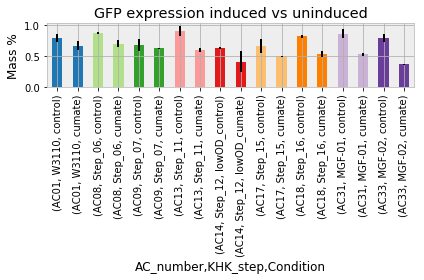

In [55]:
import matplotlib.pyplot as plt
ibaqmp_steps = ibaqmp_w_locus[khk_index.get_level_values(-1)]
ibaqmp_steps.columns = khk_index
ibaqmp_avg = ibaqmp_steps.groupby(level=['AC_number',
                                         'KHK_step',
                                         'Condition'],
                                  axis=1).mean()
ibaqmp_std = ibaqmp_steps.groupby(level=['AC_number',
                                         'KHK_step',
                                         'Condition'],
                                  axis=1).std()
ibaqmp_avg.loc[GFP].plot(kind='bar',
                         title='GFP expression induced vs uninduced',                       
                         color=double_hex,yerr=ibaqmp_std.loc[GFP])
plt.ylabel('Mass %')
plt.tight_layout()
plt.savefig('GFP_induction.pdf')

In [38]:
ibaqmp_std

AC_number                     AC01                AC08                AC09  \
KHK_step                     W3110             Step_06             Step_07   
Condition                  control    cumate   control    cumate   control   
W3110_lambdaRed.CDS.1     0.001520  0.001953  0.001359  0.004348  0.001359   
W3110_lambdaRed.CDS.100   0.000213  0.000372  0.000186  0.000359  0.000610   
W3110_lambdaRed.CDS.1007  0.002863  0.000052  0.003130  0.003577  0.000984   
W3110_lambdaRed.CDS.101   0.009222  0.006117  0.008612  0.004655  0.005488   
W3110_lambdaRed.CDS.1011  0.003541  0.002492  0.003405  0.000649  0.000676   
W3110_lambdaRed.CDS.1012  0.000696  0.001061  0.003831  0.001132  0.003209   
W3110_lambdaRed.CDS.1014  0.002633  0.000778  0.001574  0.004554  0.003232   
W3110_lambdaRed.CDS.1016  0.001169  0.000125  0.000280  0.000298  0.000435   
W3110_lambdaRed.CDS.1017  0.001263  0.000353  0.000132  0.000497  0.002515   
W3110_lambdaRed.CDS.1018  0.000291  0.000427  0.000383  0.000540  0.000218   
W3110_lambdaRed.CDS.1022  0.001061  0.000568  0.000897  0.001240  0.000945   
W3110_lambdaRed.CDS.1024  0.000737  0.000303  0.000608  0.000440  0.001033   
W3110_lambdaRed.CDS.1025  0.011749  0.003996  0.011347  0.011508  0.021125   
W3110_lambdaRed.CDS.1026  0.000115  0.000208  0.000507  0.000126  0.000304   
W3110_lambdaRed.CDS.1027  0.000826  0.001927  0.001386  0.000129  0.001551   
W3110_lambdaRed.CDS.1029  0.000007  0.000564  0.000211  0.000283  0.000205   
W3110_lambdaRed.CDS.1030  0.000654  0.000977  0.000394  0.001196  0.000382   
W3110_lambdaRed.CDS.1031  0.000251  0.000398  0.000159  0.000155  0.000258   
W3110_lambdaRed.CDS.1032  0.000000  0.000000  0.000000  0.000000  0.000035   
W3110_lambdaRed.CDS.1033  0.000121  0.001077  0.000749  0.001293  0.001183   
W3110_lambdaRed.CDS.1034  0.006246  0.004192  0.003769  0.002696  0.001898   
W3110_lambdaRed.CDS.1035  0.029630  0.011348  0.006065  0.013136  0.029992   
W3110_lambdaRed.CDS.1036  0.000756  0.000226  0.000896  0.000412  0.000568   
W3110_lambdaRed.CDS.1037  0.000393  0.000075  0.000491  0.000184  0.000286   
W3110_lambdaRed.CDS.1038  0.000802  0.001713  0.006467  0.002072  0.002705   
W3110_lambdaRed.CDS.1039  0.012866  0.002780  0.003811  0.002756  0.004136   
W3110_lambdaRed.CDS.1040  0.002690  0.000872  0.003825  0.002638  0.002695   
W3110_lambdaRed.CDS.1041  0.000165  0.000213  0.000313  0.000000  0.000572   
W3110_lambdaRed.CDS.1042  0.001558  0.000809  0.001220  0.002403  0.006754   
W3110_lambdaRed.CDS.1043  0.000576  0.000810  0.002129  0.002137  0.001770   
...                            ...       ...       ...       ...       ...   
W3110_lambdaRed.CDS.960   0.000236  0.001165  0.000803  0.000701  0.001227   
W3110_lambdaRed.CDS.961   0.000304  0.000077  0.000285  0.000289  0.000228   
W3110_lambdaRed.CDS.962   0.023690  0.140662  0.029671  0.097102  0.101098   
W3110_lambdaRed.CDS.965   0.000435  0.000616  0.000257  0.000321  0.000646   
W3110_lambdaRed.CDS.966   0.000534  0.000696  0.000819  0.001100  0.000272   
W3110_lambdaRed.CDS.967   0.001313  0.001951  0.001436  0.001089  0.005100   
W3110_lambdaRed.CDS.968   0.001979  0.002952  0.000549  0.001203  0.000723   
W3110_lambdaRed.CDS.971   0.000187  0.000903  0.000435  0.001836  0.000432   
W3110_lambdaRed.CDS.972   0.003048  0.000636  0.004850  0.000611  0.000906   
W3110_lambdaRed.CDS.973   0.001655  0.001922  0.001908  0.001281  0.001310   
W3110_lambdaRed.CDS.974   0.000070  0.000018  0.000010  0.000057  0.000330   
W3110_lambdaRed.CDS.975   0.000420  0.000885  0.000929  0.001442  0.001808   
W3110_lambdaRed.CDS.977   0.000000  0.000432  0.000000  0.000000  0.000336   
W3110_lambdaRed.CDS.978   0.000576  0.003057  0.000855  0.000262  0.000507   
W3110_lambdaRed.CDS.98    0.000114  0.000162  0.000048  0.000177  0.000110   
W3110_lambdaRed.CDS.983   0.000000  0.003275  0.000897  0.001735  0.000097   
W3110_lambdaRed.CDS.985   0.000365  0.001262  0.000036  0.001227  0.000132   
W3110_lambdaRed.CDS.98

In [26]:
st_columns = []
for AC, KHK_step, condition in ibaqmp_avg.columns:
    st_columns.append('{}_{}'.format(KHK_step, condition))
ibaqmp_avg_st = ibaqmp_avg.copy()
ibaqmp_avg_st.columns = st_columns
ibaqmp_avg_st = ibaqmp_avg_st.join(locus['Blattner'],how='left').reset_index().set_index('Blattner')

  
ibaqmp_avg_st.to_csv('E.coli_avg_iBAQ_mass_pct_induced_v_uninduced.tab',sep='\t')
ibaqmp_avg_st.loc['b1264']


index                    W3110_lambdaRed.CDS.1235
W3110_control                          0.00459823
W3110_cumate                             0.157978
Step_06_control                        0.00263138
Step_06_cumate                           0.390043
Step_07_control                        0.00195583
Step_07_cumate                           0.291279
Step_11_control                        0.00720306
Step_11_cumate                           0.290308
Step_12_lowOD_control                  0.00311701
Step_12_lowOD_cumate                    0.0136834
Step_15_control                        0.00233651
Step_15_cumate                            0.15762
Step_16_control                        0.00426322
Step_16_cumate                            0.35288
MGF-01_control                          0.0017319
MGF-01_cumate                            0.314315
MGF-02_control                          0.0031407
MGF-02_cumate                            0.587043
Name: b1264, dtype: object

In [58]:
ibaqmp_avg.loc['W3110_lambdaRed.CDS.1235']

AC_number  KHK_step  Condition    
AC01       W3110     control          0.004598
                     cumate           0.157978
AC08       Step_06   control          0.002631
                     cumate           0.390043
AC09       Step_07   control          0.001956
                     cumate           0.291279
AC13       Step_11   control          0.007203
                     cumate           0.290308
AC14       Step_12   lowOD_control    0.003117
                     lowOD_cumate     0.013683
AC17       Step_15   control          0.002337
                     cumate           0.157620
AC18       Step_16   control          0.004263
                     cumate           0.352880
AC31       MGF-01    control          0.001732
                     cumate           0.314315
AC33       MGF-02    control          0.003141
                     cumate           0.587043
Name: W3110_lambdaRed.CDS.1235, dtype: float64

In [59]:
ibaqmp.loc['W3110_lambdaRed.CDS.1235',
           ['Step_12_lowOD_control_1_61',
           'Step_12_lowOD_control_2_62',
           'Step_12_lowOD_control_3_63']].mean(), ibaqmp.loc['W3110_lambdaRed.CDS.1235',
          ['Step_12_lowOD_cumate_1_64',
           'Step_12_lowOD_cumate_2_65',
           'Step_12_lowOD_cumate_3_66']].mean()

(0.003117011906656163, 0.01368335506121159)

In [60]:
ibaqmp_w_locus[Steps].loc['W3110_lambdaRed.CDS.1235',
           ['Step_12_lowOD_control_1_61',
           'Step_12_lowOD_control_2_62',
           'Step_12_lowOD_control_3_63']].mean(), ibaqmp_w_locus.loc['W3110_lambdaRed.CDS.1235',
          ['Step_12_lowOD_cumate_1_64',
           'Step_12_lowOD_cumate_2_65',
           'Step_12_lowOD_cumate_3_66']].mean()

(0.003117011906656163, 0.01368335506121159)

## Dashboard cleanup

In [28]:
%matplotlib inline
import matplotlib
colors = [(0.12156862745098039, 0.47058823529411764, 0.70588235294117652),
          (0.69803921568627447, 0.87450980392156863, 0.54117647058823526),
          (0.20000000000000001, 0.62745098039215685, 0.17254901960784313),
          (0.98431372549019602, 0.60392156862745094, 0.59999999999999998),
          (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
          (0.99215686274509807, 0.74901960784313726, 0.43529411764705883),
          (1.0, 0.49803921568627452, 0.0),
          (0.792156862745098, 0.69803921568627447, 0.83921568627450982),
          (0.41568627450980394, 0.23921568627450981, 0.60392156862745094),
          (0.69411764705882351, 0.34901960784313724, 0.15686274509803921)]
hex_colors = []
double_hex_colors = []
for r,g,b in colors:
    hex_colors.append(matplotlib.colors.to_hex([r,g,b]))
    double_hex_colors.append(matplotlib.colors.to_hex([r,g,b]))
    double_hex_colors.append(matplotlib.colors.to_hex([r,g,b]))
hex_colors

['#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#b15928']

In [29]:
double_hex = [hex_colors[i//2] for i in range(2*len(hex_colors)) ]
double_hex

['#1f78b4',
 '#1f78b4',
 '#b2df8a',
 '#b2df8a',
 '#33a02c',
 '#33a02c',
 '#fb9a99',
 '#fb9a99',
 '#e31a1c',
 '#e31a1c',
 '#fdbf6f',
 '#fdbf6f',
 '#ff7f00',
 '#ff7f00',
 '#cab2d6',
 '#cab2d6',
 '#6a3d9a',
 '#6a3d9a',
 '#b15928',
 '#b15928']

In [32]:
hextuple_hex = [hex_colors[i//6] for i in range(6*len(hex_colors)) ]
hextuple_hex

['#1f78b4',
 '#1f78b4',
 '#1f78b4',
 '#1f78b4',
 '#1f78b4',
 '#1f78b4',
 '#b2df8a',
 '#b2df8a',
 '#b2df8a',
 '#b2df8a',
 '#b2df8a',
 '#b2df8a',
 '#33a02c',
 '#33a02c',
 '#33a02c',
 '#33a02c',
 '#33a02c',
 '#33a02c',
 '#fb9a99',
 '#fb9a99',
 '#fb9a99',
 '#fb9a99',
 '#fb9a99',
 '#fb9a99',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#e31a1c',
 '#fdbf6f',
 '#fdbf6f',
 '#fdbf6f',
 '#fdbf6f',
 '#fdbf6f',
 '#fdbf6f',
 '#ff7f00',
 '#ff7f00',
 '#ff7f00',
 '#ff7f00',
 '#ff7f00',
 '#ff7f00',
 '#cab2d6',
 '#cab2d6',
 '#cab2d6',
 '#cab2d6',
 '#cab2d6',
 '#cab2d6',
 '#6a3d9a',
 '#6a3d9a',
 '#6a3d9a',
 '#6a3d9a',
 '#6a3d9a',
 '#6a3d9a',
 '#b15928',
 '#b15928',
 '#b15928',
 '#b15928',
 '#b15928',
 '#b15928']

## KHK step color cleanup

In [71]:
dir(matplotlib.colors)

['BASE_COLORS',
 'BoundaryNorm',
 'CSS4_COLORS',
 'ColorConverter',
 'Colormap',
 'LightSource',
 'LinearSegmentedColormap',
 'ListedColormap',
 'LogNorm',
 'NoNorm',
 'Normalize',
 'PowerNorm',
 'Sized',
 'SymLogNorm',
 'TABLEAU_COLORS',
 'XKCD_COLORS',
 '_ColorMapping',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_colors_full_map',
 '_is_nth_color',
 '_sanitize_extrema',
 '_to_rgba_no_colorcycle',
 '_vector_magnitude',
 'cbook',
 'cnames',
 'colorConverter',
 'from_levels_and_colors',
 'get_named_colors_mapping',
 'hex2color',
 'hexColorPattern',
 'hsv_to_rgb',
 'is_color_like',
 'itertools',
 'makeMappingArray',
 'np',
 're',
 'rgb2hex',
 'rgb_to_hsv',
 'same_color',
 'to_hex',
 'to_rgb',
 'to_rgba',
 'to_rgba_array']

In [98]:
!pwd

/Users/zuck016/Projects/E.coli/synbio-ai/CCO-divergence-analysis


In [3]:
step_integers = (655104, 65535, 590079, 16711924, 16711700,)
def get_RGB_from_I(RGBint):
    blue =  RGBint & 255
    green = (RGBint >> 8) & 255
    red =   (RGBint >> 16) & 255
    return red, green, blue

def get_I_from_RGB(rgb):
    red = rgb[0]
    green = rgb[1]
    blue = rgb[2]
    print(red, green, blue)
    RGBint = (red<<16) + (green<<8) + blue
    return RGBint

def get_RGB_from_hex(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def get_hex_from_I( RGBint ):
    r,g,b = get_RGB_from_I( RGBint )
    return "#{0:02x}{1:02x}{2:02x}".format(r,g,b)
step_hex = [get_hex_from_I(step) for step in step_integers]
step_hex

['#09ff00', '#00ffff', '#0900ff', '#ff00f4', '#ff0014']

In [104]:
colorblind_hex = {'Step10': '#0072B2',
 'Step09': '#E69F00',
 'W3110': '#F0E442',
 'Step05': '#009E73'}
colorblind_rgb = dict([(step, get_RGB_from_hex(chex)) for step, chex in colorblind_hex.items()])
colorblind_I = dict([(step, get_I_from_RGB(rgb)) for step, rgb in colorblind_rgb.items()])
colorblind_I

0 114 178
230 159 0
240 228 66
0 158 115


{'Step05': 40563, 'Step09': 15113984, 'Step10': 29362, 'W3110': 15787074}

In [4]:
viridis_hex = {32:'#440154', 16:'#3B518A', 8:'#208F8C', 4:'#5BC862', 2:'#FDE724'}

viridis_rgb = dict([(step, get_RGB_from_hex(chex)) for step, chex in viridis_hex.items()])
viridis_I = dict([(step, get_I_from_RGB(rgb)) for step, rgb in viridis_rgb.items()])
viridis_I

68 1 84
59 81 138
32 143 140
91 200 98
253 231 36


{2: 4456788, 4: 3887498, 8: 2133900, 16: 6015074, 32: 16639780}

In [5]:
accent_hex = {1:'#7fc97f', 2:'#beaed4', 3:'#fdc086', 5:'#ffff99', 8:'#386cb0', 25:'#f0027f'}


accent_rgb = dict([(step, get_RGB_from_hex(chex)) for step, chex in accent_hex.items()])
accent_I = dict([(step, get_I_from_RGB(rgb)) for step, rgb in accent_rgb.items()])
accent_I

127 201 127
190 174 212
253 192 134
255 255 153
56 108 176
240 2 127


{1: 8374655, 2: 12496596, 3: 16629894, 5: 16777113, 8: 3697840, 25: 15729279}

<Figure size 432x288 with 0 Axes>

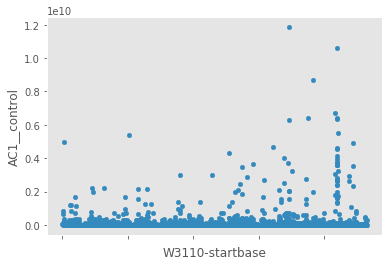

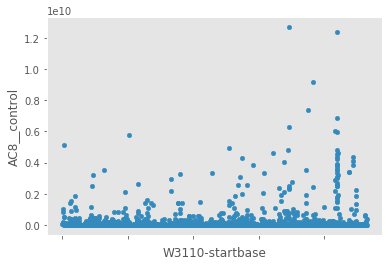

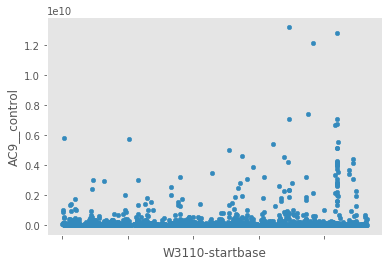

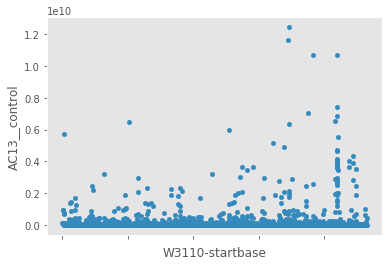

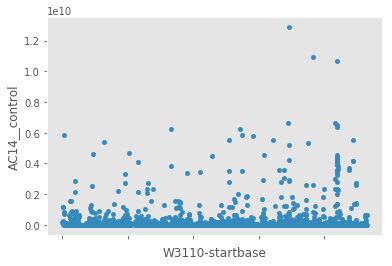

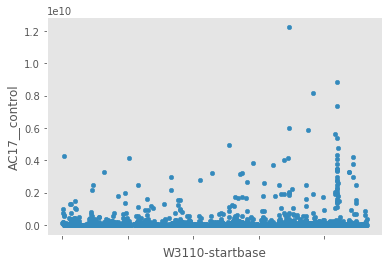

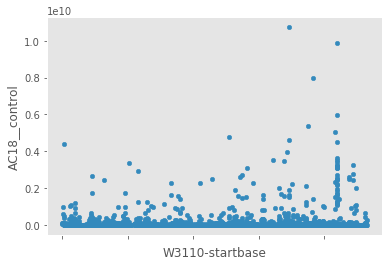

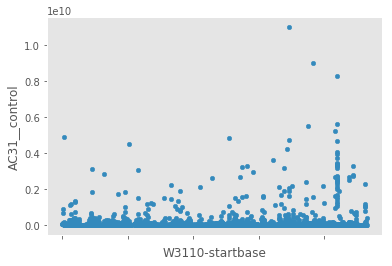

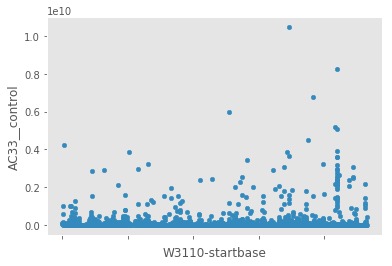

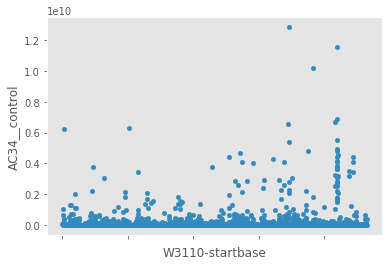

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.style.use('ggplot')
conditions = ['AC{}_'.format(condition) for condition in [1,8,9,13,14,17,18,31,33,34]]
for cond in conditions:
    for induction in ['cumate','control']:
        ibaq_w_locus['{}_{}'.format(cond, induction)] = ibaq_w_locus[[c 
                                                                        for c in ibaq_col 
                                                                          if cond in c 
                                                                          and induction in c]].mean(axis=1)
 
    fig = plt.figure() # Create matplotlib figure
    control_ax = fig.add_subplot(111) # Create matplotlib axes


    ibaq_w_locus.sort_values('W3110-startbase').plot(x='W3110-startbase', 
                                                     y='{}_{}'.format(cond,'control'),
                                                     secondary_y='{}_{}'.format(cond,'cumate'),
                                                     ax=control_ax,
                                                     kind='scatter',
                                                     )
    control_ax.xaxis.set_ticklabels([])

    plt.savefig('iBAQ_{}_cumate_vs_control_bar_on_genome.pdf'.format(cond))



<Figure size 432x288 with 0 Axes>

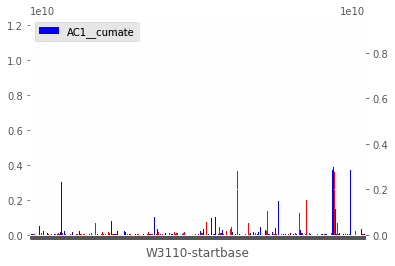

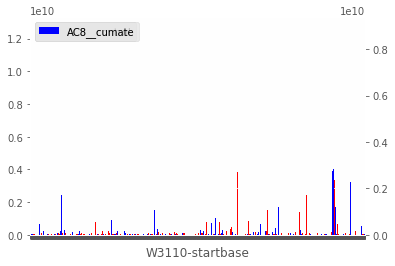

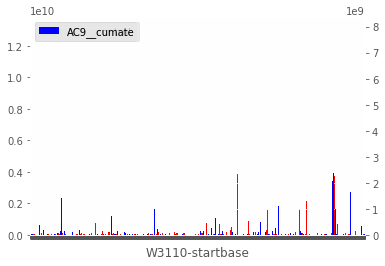

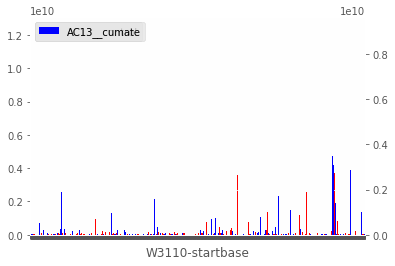

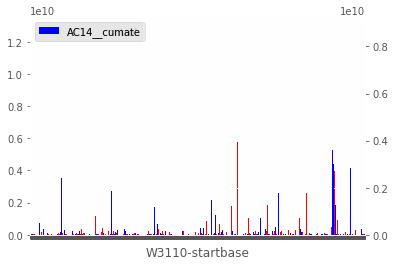

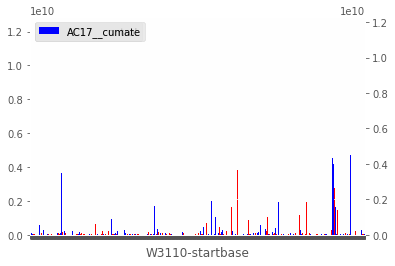

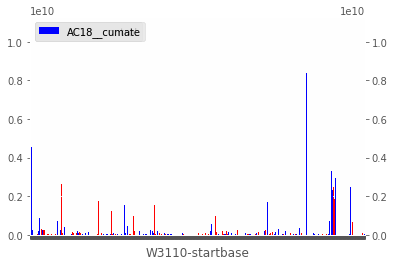

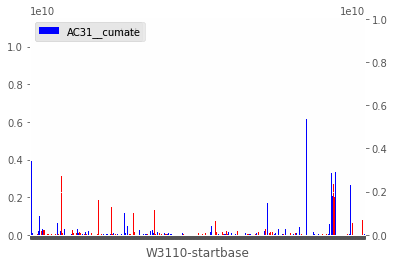

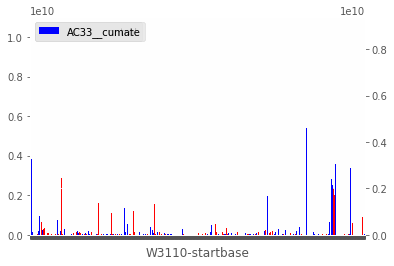

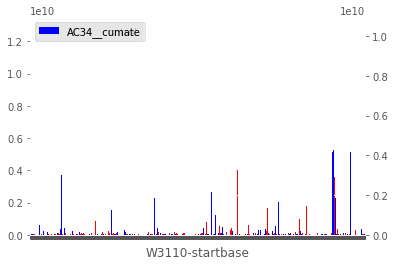

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
plt.style.use('ggplot')
conditions = ['AC{}_'.format(condition) for condition in [1,8,9,13,14,17,18,31,33,34]]
for cond in conditions:
    

    for induction in ['cumate','control']:
        ibaq_w_locus['{}_{}'.format(cond, induction)] = ibaq_w_locus[[c 
                                                                        for c in ibaq_col 
                                                                          if cond in c 
                                                                          and induction in c]].\
                                                                    mean(axis=1)
        
    fig = plt.figure() # Create matplotlib figure
    control_ax = fig.add_subplot(111) # Create matplotlib axes
    control_ax.xaxis.set_ticklabels([])

    cumate_ax = control_ax.twinx()

    ibaq_w_locus.sort_values('W3110-startbase').plot(x='W3110-startbase', 
                                                     y='{}_{}'.format(cond,'control'),
                                                     ax=control_ax,
                                                     kind='bar',
                                                     color='red',
                                                     position=0
                                                     )
    
    ibaq_w_locus.sort_values('W3110-startbase').plot(x='W3110-endbase', 
                                                     y='{}_{}'.format(cond,'cumate'),
                                                     ax=cumate_ax,
                                                     kind='bar',
                                                     color='blue',position=1)
    cumate_ax.xaxis.set_ticklabels([])

    plt.savefig('iBAQ_{}_cumate_vs_control_bar_on_genome.pdf'.format(cond))



In [48]:
pg.set_index('Protein IDs').loc[nonnative,lfq_col]

,LFQ intensity AC1_control_1_01,LFQ intensity AC1_control_2_02,LFQ intensity AC1_control_3_03,LFQ intensity AC1_cumate_1_04,LFQ intensity AC1_cumate_2_05,LFQ intensity AC1_cumate_3_06,LFQ intensity AC13_control_1_19,LFQ intensity AC13_control_2_20,LFQ intensity AC13_control_3_21,LFQ intensity AC13_cumate_1_22,...,LFQ intensity AC8_control_3_09,LFQ intensity AC8_cumate_1_10,LFQ intensity AC8_cumate_2_11,LFQ intensity AC8_cumate_3_12,LFQ intensity AC9_control_1_13,LFQ intensity AC9_control_2_14,LFQ intensity AC9_control_3_15,LFQ intensity AC9_cumate_1_16,LFQ intensity AC9_cumate_2_17,LFQ intensity AC9_cumate_3_18
Protein IDs,,,,,,,,,,,,,,,,,,,,,
cat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,26667000000
CON__A2A4G1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CON__ENSEMBL:ENSBTAP00000025008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CON__ENSEMBL:ENSBTAP00000031900,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CON__ENSEMBL:ENSBTAP00000038253,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CON__P02533;CON__Q61782,52726000,74558000,0,51137000,25950000,743020000,155700000,249870000,34007000,162750000,...,95603000,65485000,116460000,30228000,39833000,28160000,34537000,33545000,156380000,1732600000
CON__P02535-1,0,0,0,42393000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CON__P02538,238970000,157990000,76240000,0,138280000,384700000,144550000,363490000,34456000,122550000,...,78887000,332800000,149670000,66549000,215780000,42417000,293820000,210550000,155270000,1543800000
CON__P02662,214030000,0,0,0,0,19377000,22988000,18215000,0,65192000,...,7634800,12280000,11586000,229490000,0,12631000,0,0,15805000,45127000


In [49]:
print('\n'.join(pg.columns))

Protein IDs
Majority protein IDs
Peptide counts (all)
Peptide counts (razor+unique)
Peptide counts (unique)
Fasta headers
Number of proteins
Peptides
Razor + unique peptides
Unique peptides
Peptides AC1_control_1_01
Peptides AC1_control_2_02
Peptides AC1_control_3_03
Peptides AC1_cumate_1_04
Peptides AC1_cumate_2_05
Peptides AC1_cumate_3_06
Peptides AC13_control_1_19
Peptides AC13_control_2_20
Peptides AC13_control_3_21
Peptides AC13_cumate_1_22
Peptides AC13_cumate_2_23
Peptides AC13_cumate_3_24
Peptides AC14_control_1_25
Peptides AC14_control_2_26
Peptides AC14_control_3_27
Peptides AC14_cumate_1_28
Peptides AC14_cumate_2_29
Peptides AC14_cumate_3_30
Peptides AC14_lowOD_control_1_61
Peptides AC14_lowOD_control_2_62
Peptides AC14_lowOD_control_3_63
Peptides AC14_lowOD_cumate_1_64
Peptides AC14_lowOD_cumate_2_65
Peptides AC14_lowOD_cumate_3_66
Peptides AC17_control_1_31
Peptides AC17_control_2_32
Peptides AC17_control_3_33
Peptides AC17_cumate_1_34
Peptides AC17_cumate_2_35
Peptides AC

In [8]:
locus.reset_index().set_index('Blattner')

,E_coli_K12_W3110_lambdaRed,E_coli_K12_W3110,W3110-Name,W3110-Accession,MG1655-ID,W3110-startbase,W3110-endbase,W3110-strand,MG1655-startbase,MG1655-endbase,MG1655-strand,sort_order
Blattner,,,,,,,,,,,,
b0034,W3110_lambdaRed.CDS.30,JW0033,caiF,ECK0035,G6088,34300,34695,+,34300,34695,+,30
b3702,W3110_lambdaRed.CDS.3578,JW3679,dnaA,ECK3694,EG10235,3756686,3758089,+,3882326,3883729,-,3578
NIL,W3110_lambdaRed.CDS.358,JW0352,insD-1,ECK0358,G0-10543,380898,381803,+,2068952,2070180,-,358
NIL,W3110_lambdaRed.CDS.358,JW1397,insD-1,ECK0358,NIL,1469635,1470540,-,NIL,NIL,NIL,358
NIL,W3110_lambdaRed.CDS.358,JW1975,insD-1,ECK0358,NIL,2071089,2071994,-,NIL,NIL,NIL,358
NIL,W3110_lambdaRed.CDS.358,JW2826,insD-1,ECK0358,NIL,2995028,2995933,-,NIL,NIL,NIL,358
NIL,W3110_lambdaRed.CDS.358,JW3013,insD-1,ECK0358,NIL,3185166,3186071,+,NIL,NIL,NIL,358
NIL,W3110_lambdaRed.CDS.358,JW4230,insD-1,ECK0358,NIL,4503275,4504180,+,NIL,NIL,NIL,358
b3700,W3110_lambdaRed.CDS.3580,JW3677,recF,ECK3692,EG10828,3759194,3760267,+,3880148,3881221,-,3580


# Differential abundance

In [10]:
import pandas as pd
locus = pd.read_table('../../lambdaRed_W3110_MG1655.locus.tab',index_col='E_coli_K12_W3110_lambdaRed')
locus

conditions = ['AC{}_'.format(condition) for condition in [1,8,9,13,14,17,18,31,33,34]]
da = {}
for sheet_name in conditions:
    da[sheet_name] = pd.read_excel('../../DifferentialAbundance/inducedvuninduced.xlsx',
                                   sheet_name=sheet_name).\
                        join(locus.\
                             reset_index().\
                             set_index('Blattner'), sort=True)


In [22]:
diff = pd.concat(da,axis=1, sort=True)
lfc = diff.xs('logFC', axis=1, level=1)
lfc.to_csv('../../DifferentialAbundance/DiffLogFoldChange.tab',sep='\t')
diff

AC13_             \
                                                       logFC    AveExpr   
CON__P02533                                        -0.302998  26.561955   
CON__P02538                                        -0.665463  26.556077   
CON__P02662                                              NaN        NaN   
CON__P02769                                              NaN        NaN   
CON__P04264                                        -0.134273  31.645012   
CON__P07477                                         1.231907  30.202648   
CON__P13645                                        -0.041407  31.186269   
CON__P13647                                              NaN        NaN   
CON__P35527                                        -0.241105  30.323328   
CON__P35908                                        -0.311516  29.692857   
CON__Q3SX28                                         0.985029  28.219710   
CON__Q7Z794                                        -0.527927  25.397248   
CON__Q86YZ3                                        -1.083930  25.383028   
REV__W3110_lambdaRed.CDS.2076                            NaN        NaN   
REV__W3110_lambdaRed.CDS.2445                      -0.825870        NaN   
REV__W3110_lambdaRed.CDS.2474                            NaN        NaN   
REV__W3110_lambdaRed.CDS.2644                            NaN        NaN   
REV__W3110_lambdaRed.CDS.2915                      -3.004980  25.530703   
REV__W3110_lambdaRed.CDS.3108                      -0.825870        NaN   
REV__W3110_lambdaRed.CDS.4247                       0.828673  27.476174   
REV__W3110_lambdaRed.CDS.700                       -0.062820  24.186660   
REV__W3110_lambdaRed.CDS.713                             NaN        NaN   
REV__W3110_lambdaRed.CDS.755                             NaN        NaN   
REV__W3110_lambdaRed.CDS.781                        3.101357  27.224053   
REV__W3110_lambdaRed.CDS.854                       -0.888211  29.506442   
W3110_lambdaRed.CDS.1456                           -0.129271  25.736716   
W3110_lambdaRed.CDS.2082                                 NaN        NaN   
W3110_lambdaRed.CDS.3390                           -0.250155  31.431128   
W3110_lambdaRed.CDS.4101                            0.344770  26.528388   
W3110_lambdaRed.CDS.540;W3110_lambdaRed.CDS.369...  0.756213  25.326879   
...                                                      ...        ...   
b4391                                              -0.026930  32.792223   
b4392                                               0.461192  29.007401   
b4393                                               1.038287  27.953299   
b4394                                               0.299664  27.394035   
b4395                                               0.047526  28.536517   
b4396                                               0.473220  28.888948   
b4397                                               0.563981  28.375642   
b4401                                               0.005923  32.306087   
b4403                                              -0.294601  27.271642   
b4406                                              -0.251959  28.148553   
b4411                                               1.473273  29.753370   
b4461                                              -0.300748  26.265351   
b4466                                                    NaN        NaN   
b4469                                              -0.993886  27.018477   
b4472                                               0.000090  27.397758   
b4479                                               0.323280  26.247716   
b4481                                               0.513023  29.029233   
b4484                                               1.112266  28.130861   
b4488                                                    NaN        NaN   
b4536                                              -0.347739  26.247640   
b4537                                              -0.608139  29.544479   
b4554

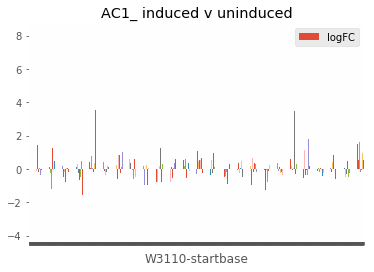

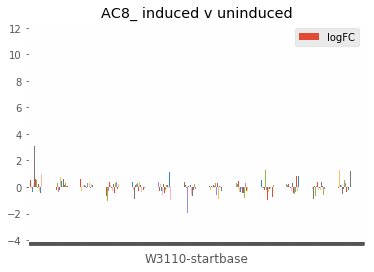

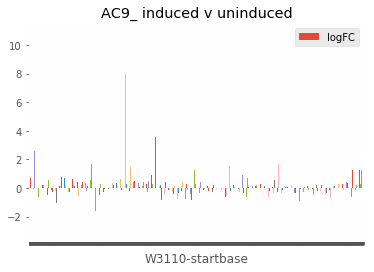

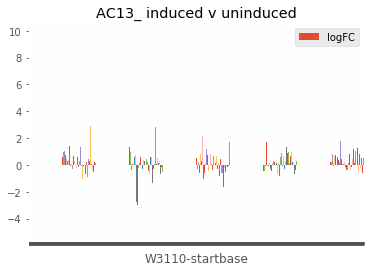

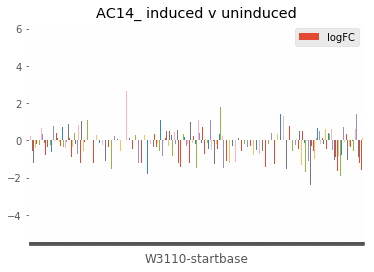

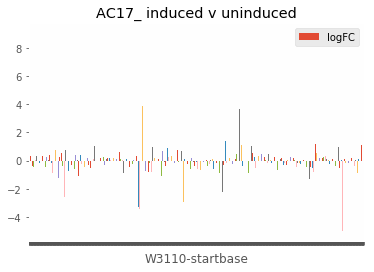

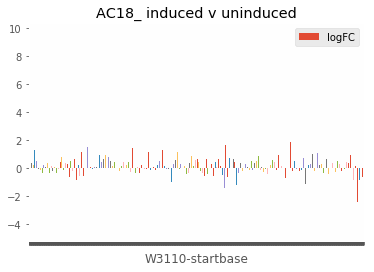

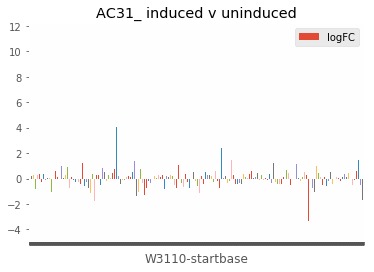

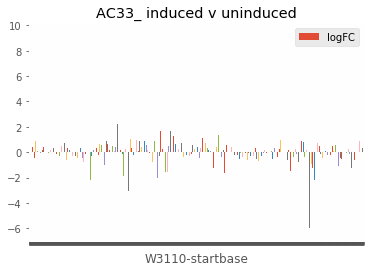

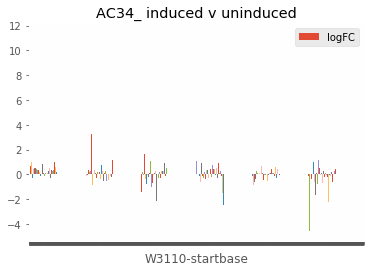

In [39]:
#f, a = plt.subplots(3,4)
i,j = 0,0
for k, sheet_name in enumerate(conditions):
    ax = da[sheet_name].\
        sort_values('W3110-startbase').\
        plot(x='W3110-startbase',
             y='logFC',
            kind='bar',
            )
            #ax=a[i][j])
    ax.xaxis.set_ticklabels([0,])
    ax.set_title("{} induced v uninduced".format(sheet_name))
    plt.savefig("{}_induced_v_uninduced.pdf".format(sheet_name))

[Text(0,0,'0'), Text(0,0,'40')]

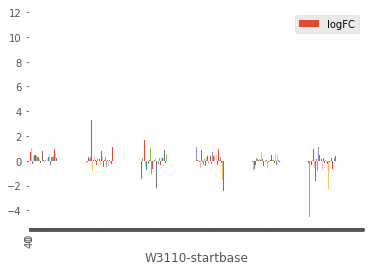

In [46]:
ax = da[sheet_name].\
        sort_values('W3110-startbase').\
        plot(x='W3110-startbase',
             y='logFC',
            kind='bar',
            )
            #ax=a[i][j])
ax.xaxis.set_ticklabels([0,40])

,logFC,AveExpr,t,P.Value,adj.P.Val,B,symbol,E_coli_K12_W3110_lambdaRed,E_coli_K12_W3110,W3110-Name,W3110-Accession,MG1655-ID,W3110-startbase,W3110-endbase,W3110-strand,MG1655-startbase,MG1655-endbase,MG1655-strand,sort_order
b0002,0.024276,31.264633,0.266040,0.798367,0.882717,-7.836456,thrA,W3110_lambdaRed.CDS.1,JW0001,thrA,ECK0002,EG10998,337.0,2799.0,+,337,2799,+,1.0
b0003,-0.437252,28.235069,-3.076497,0.019399,0.075165,-4.507869,thrB,W3110_lambdaRed.CDS.2,JW0002,thrB,ECK0003,EG10999,2801.0,3733.0,+,2801,3733,+,2.0
b0004,0.174695,31.036905,1.702505,0.135271,0.271700,-6.496074,thrC,W3110_lambdaRed.CDS.3,JW0003,thrC,ECK0004,EG11000,3734.0,5020.0,+,3734,5020,+,3.0
b0006,0.286658,31.121709,2.646338,0.035115,0.107239,-5.136580,yaaA,W3110_lambdaRed.CDS.5,JW0005,yaaA,ECK0006,EG10011,5683.0,6459.0,-,5683,6459,-,5.0
b0008,0.187819,33.951250,1.691723,0.137364,0.274620,-6.510701,talB,W3110_lambdaRed.CDS.7,JW0007,talB,ECK0008,EG11556,8238.0,9191.0,+,8238,9191,+,7.0
b0009,-0.264447,29.363310,-1.771890,0.122520,0.256434,-6.401120,mog,W3110_lambdaRed.CDS.8,JW0008,mog,ECK0009,EG11511,9306.0,9893.0,+,9306,9893,+,8.0
b0014,0.800665,35.622582,8.167050,0.000113,0.002946,1.194795,dnaK,W3110_lambdaRed.CDS.12,JW0013,dnaK,ECK0014,EG10241,12163.0,14079.0,+,12163,14079,+,12.0
b0015,0.709621,31.530297,7.298223,0.000222,0.004727,0.439119,dnaJ,W3110_lambdaRed.CDS.13,JW0014,dnaJ,ECK0015,EG10240,14168.0,15298.0,+,14168,15298,+,13.0
b0020,-0.582238,29.869573,-2.134385,0.072797,0.175891,-5.887070,nhaR,W3110_lambdaRed.CDS.16,JW0019,nhaR,ECK0021,EG11078,18715.0,19620.0,+,18715,19620,+,16.0
b0023,-0.005374,34.216179,-0.025636,0.980309,0.985106,-7.876581,rpsT,W3110_lambdaRed.CDS.18,JW0022,rpsT,ECK0024,EG10919,20815.0,21078.0,-,20815,21078,-,18.0


In [ ]:
for sheet_name in conditions:
    

# KHK library 

In [27]:
import pandas as pd
locus = pd.read_table('../../lambdaRed_W3110_MG1655.locus.tab',index_col='E_coli_K12_W3110_lambdaRed')
locus

,E_coli_K12_W3110,W3110-Name,W3110-Accession,MG1655-ID,Blattner,W3110-startbase,W3110-endbase,W3110-strand,MG1655-startbase,MG1655-endbase,MG1655-strand,sort_order
E_coli_K12_W3110_lambdaRed,,,,,,,,,,,,
W3110_lambdaRed.CDS.30,JW0033,caiF,ECK0035,G6088,b0034,34300,34695,+,34300,34695,+,30
W3110_lambdaRed.CDS.3578,JW3679,dnaA,ECK3694,EG10235,b3702,3756686,3758089,+,3882326,3883729,-,3578
W3110_lambdaRed.CDS.358,JW0352,insD-1,ECK0358,G0-10543,NIL,380898,381803,+,2068952,2070180,-,358
W3110_lambdaRed.CDS.358,JW1397,insD-1,ECK0358,NIL,NIL,1469635,1470540,-,NIL,NIL,NIL,358
W3110_lambdaRed.CDS.358,JW1975,insD-1,ECK0358,NIL,NIL,2071089,2071994,-,NIL,NIL,NIL,358
W3110_lambdaRed.CDS.358,JW2826,insD-1,ECK0358,NIL,NIL,2995028,2995933,-,NIL,NIL,NIL,358
W3110_lambdaRed.CDS.358,JW3013,insD-1,ECK0358,NIL,NIL,3185166,3186071,+,NIL,NIL,NIL,358
W3110_lambdaRed.CDS.358,JW4230,insD-1,ECK0358,NIL,NIL,4503275,4504180,+,NIL,NIL,NIL,358
W3110_lambdaRed.CDS.3580,JW3677,recF,ECK3692,EG10828,b3700,3759194,3760267,+,3880148,3881221,-,3580


In [30]:
khk_ibaq = pd.read_table('E_coli_iBAQ_data_frame.txt',index_col='protein_ID')
khk_ibaq_locus = khk_ibaq.join(locus,how='inner').reset_index().set_index('Blattner')
khk_ibaq_locus.to_csv('E_coli_iBAQ_with_locus_ids.tab',sep='\t')
